<p style="text-align: center;">
    Министерство науки и высшего образования Российской Федерации<br>
    Федеральное государственное автономное образовательное учреждение высшего образования «Национальный исследовательский Нижегородский государственный университет им. Н.И. Лобачевского»<br>
    <br>
    Институт Информационных технологий, математики и механики<br>
    <br><br><br>
    Выпускная квалифиционная работа магистра<br>
    <h1 style="text-align: center;">Исследование влияния различных способов улучшения точности сегментации ЭКГ</h1>
</p>
<br><br><br><br><br>
<p style = "text-align: left; margin-left: 80%;">
    Выполнил:<br>
    студент гр. 381803-1<br>
    <p style = "text-align: left; margin-left: 90%;">
        Мешалкин Н.А.
    </p>
</p>
<br><br><br>
<p style = "text-align: left; margin-left: 80%;">
    Проверил:<br>
    директор ИИТММ<br>
    <p style = "text-align: left; margin-left: 90%;">
        Золотых Ю.Н.
    </p>
</p>
<br><br><br><br>
<p style="text-align: center">
    Нижний Новгород<br>
    2024
</p>

## Введение

**Описание работы:**
Данная работа направлена на изучения влияния на точность сегментационных нейросетей различных способов улучшения точности сегментации. В этом исследовании будет рассмотрено несколько вариантов нейросетей с различными внутренними слоями от самых простых до самых сложных. В качестве нейронной сети, результаты которой следует превзойти, представлена сегментационная нейросеть, подготовленная учеными ННГУ. Данная сеть написана на основе популярной сегментационной сети U-Net. Отличие лишь в том, что данная нейросеть адаптирована под 1D сигнал. Также в качестве базы данных была выбрана собственная база данных ЭКГ, собранная сотрудниками ННГУ. В основе этой базы данных лежат сигналы ЭКГ в 12 отведениях 746 пациентов с частотой дискретизации 500 Гц.

**Цель работы:**
Необходимо проанализировать влияние на точность нейросети различных внутренних слоев. Провести сравнительный анализ, а также сделать заключение о налиучшем варианте нейронной сети, которая будет показывать наилучшую точность.

Данная работа состоит из двух частей: 
1) Разработка собственной нейросети для сегментации сигналов ЭКГ. Разработка будет разобрана шаг за шагом, чтобы можно было отследить влияние на точность различных внутренних слоев, которые будут постепенно добавляться в нейронную сеть.
2) Работа над сегментационной нейросетью от ученых ННГУ. 

## Часть 1. Разработка собственной нейронной сети.

Данный раздел состоит из множества шагов, потому что разработка нейронной сети сложный и трудоемкий процесс. 

### 1.1 Анализ данных.

В качестве данных мы используем сигнал ЭКГ в 12 отведениях с частотой дискретизации 500Гц. В первую очередь необходимо посмотреть на данные.

In [40]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.nn import Module
from typing import Literal
import numpy as np
from torch.utils.data import Dataset
import glob
import torch
import torch.nn.functional as F
from torch import optim
import torch.nn.functional as functional
import matplotlib.pyplot as plt
from torchsummary import summary
import time

import os

from scripts.models import UNet, Encoder, Decoder
from scripts.dataset import SegmentationDataset, get_item_dataset
from scripts.metric import SegmentationMetric
from scripts.plotter import plot_signal_with_mask, check_segmentation
from scripts.analyser import Analyser

from sklearn.model_selection import train_test_split

from lightning.pytorch import Trainer
from lightning.pytorch import LightningModule
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from scripts.plotter import plot_signal_with_mask, print_ecg

In [41]:
# Вспомогательные функции, превращающие маску в сегментацию
sample_rate = 500
v_to_del = {1:'p', 2:'qrs', 3:'t'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 12
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'p':[], 'qrs':[], 't':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation

wave_type_to_color = {
    "p": "yellow",
    "qrs": "red",
    "t": "green"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    for wave_type in ["p", "qrs", "t"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

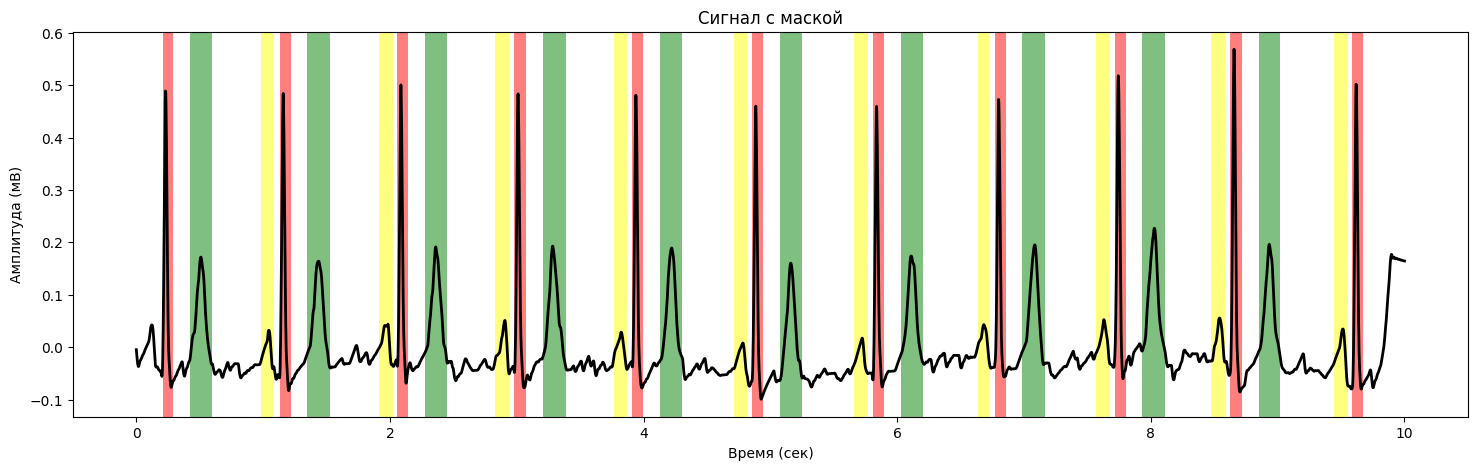

In [42]:
signals = np.load("/home/meshalkin/Diplom/ludb/data/signals/00001_hr_unsupervised.npy")
masks = np.load("/home/meshalkin/Diplom/ludb/data/masks/00001_hr_unsupervised.npy")
index = 10
plot_signal_with_mask(signals[index], masks[index])

Так выглядит сигнал и оригинальная маска. Будем надеяться, что наша нейросеть, покажет такие же результаты!

### 1.2. Разработка валидационного и тренировочного датасета

В коде ниже проводится разделение данных на тренировочный и валидационный датасеты:

In [44]:
def get_dataset(paths):
    return [np.load(f'/home/meshalkin/Diplom/ludb/data/signals/{x}') for x in paths], \
           [np.load(f'/home/meshalkin/Diplom/ludb/data/masks/{x}') for x in paths]

ecg_list = sorted(os.listdir('/home/meshalkin/Diplom/ludb/data/signals/'))
ecg_list = [x for x in ecg_list if x.split('_')[-1] != 'unsupervised.npy']

train_list, test_list = train_test_split(ecg_list, test_size=0.2, shuffle=True, random_state=42)

for x in sorted(os.listdir('/home/meshalkin/Diplom/ludb/data/signals/')):
    if x.split('_')[-1] == 'unsupervised.npy':
        train_list.append(x)

x_train, y_train = get_dataset(train_list)
x_test, y_test = get_dataset(test_list)

# мб сделать stratify относительно kva, ludb, unsuper?

train_dataset = SegmentationDataset('cuda', train_list, x_train, y_train, common_mask=True, for_train=True)
val_dataset = SegmentationDataset('cuda', test_list, x_test, y_test, common_mask=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Lenght of train dataset = {len(train_dataset)} samples")
print(f"Lenght of val dataset = {len(val_dataset)} samples")

Lenght of train dataset = 670 samples
Lenght of val dataset = 99 samples


### 1.3. Разработка модуля для обработки нейронных сетей.

В коде ниже происходит разработка модуля для построения обертки вокруг нейронных сетей. В этом классе реализована тренировка и валидации моделей.

In [109]:
class NNModule(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.save_hyperparameters()
       
        self.model = model
        self.loss = nn.CrossEntropyLoss(ignore_index=4, label_smoothing=0)
        self.metric = SegmentationMetric('p', 'all', return_type='f1', samples=150)
        
        # Для хранения метрик
        self.val_loss_history = []
        self.val_p_wave_history = []

    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
            x = x.unsqueeze(0) if len(x.shape) == 2 else x
        x = x.to(self.device)
        logits = self.model(x)
        y_pred = logits.argmax(axis=1)
        return y_pred.cpu().detach().numpy()
        
    def training_step(self, batch, batch_idx):
        _, x, y = batch
        logits = self.model(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        _, x, y = batch
        logits = self.model(x)
        loss = self.loss(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        metrics = self.get_metric(x, y, 'val')
        for key, value in metrics.items():
            self.log(key, value, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return {'val_loss': loss, 'val_p_wave': metrics['val_p_wave']}
    
    def on_validation_epoch_end(self):
        avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
        avg_p_wave = torch.mean(torch.tensor(self.trainer.callback_metrics['val_p_wave'])).item()
        
        # Сохранение значений метрик
        self.val_loss_history.append(avg_loss)
        self.val_p_wave_history.append(avg_p_wave)
        
        print(f"Epoch {self.current_epoch}, Val Loss: {avg_loss:.4f}, Val P Wave: {avg_p_wave:.4f}")
    
    def get_metric(self, x, y_true, prefix):
        y_true = y_true.cpu().detach().numpy()
        y_pred = self.predict(x)
        
        f1_score = self.metric(y_pred, y_true)
        
        return {f'{prefix}_p_wave': f1_score}
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters())
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=50, verbose=True)
        return [optimizer], [{"scheduler": scheduler, 
                              "interval": "epoch",
                              "monitor": "val_loss"}]
    
    def plot_metrics(self):
        epochs = range(len(self.val_loss_history))
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.val_loss_history, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss over Epochs')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.val_p_wave_history, label='Val P Wave')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('Validation P Wave F1 Score over Epochs')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

Также введем функцию для вывода информации о модели:

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

def print_information_about_model(model, batch_size, num_channels, length):
    # Создание случайных входных данных
    inputs = torch.randn(batch_size, num_channels, length)
    
    start_time = time.time()
    # Проход через сеть
    outputs = model(inputs.to(device))
    inference_time = time.time() - start_time
    
    print(f"Размер входа: {inputs.shape}")
    print(f"Размер выхода: {outputs.shape}")  # Распечатает: torch.Size([2, 4, 5000])
    summary(model.to(device), input_size=(12, 5000))
    print(f"Inference Time: {inference_time:.7f} seconds")

### 1.4. Разработка собственной неросети.

#### 1.4.1 Разработка версии №1. Простейшая full-convolutional сеть.

Начнем с простой нейронной сети с тремя сверточноми слоями внутри. Так как маска распространяется вдоль всех каналов, мы можем объединить их и выдавать результат в виде распределения вероятностей по нашим классам. Точнее будет сказать, что все таки выход будет иметь ненормализированные числа, они нормализуются в процессе обучения.  
То есть, наши данные имеют размер [2,12,5000], где 2 - размер батча, 12 - количество каналов, 5000 - длина сигнала, то выход нейронной сети будет иметь размер [2,4,5000], где 2 - размер батча, 12 - количество классов, 5000 - длина сигнала.

In [116]:
class SegmentationNetwork(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(SegmentationNetwork, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x



# Создание модели
model = SegmentationNetwork(num_channels, num_classes)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           2,368
            Conv1d-2             [-1, 64, 5000]          12,352
            Conv1d-3              [-1, 4, 5000]             772
Total params: 15,492
Trainable params: 15,492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.23
Forward/backward pass size (MB): 5.04
Params size (MB): 0.06
Estimated Total Size (MB): 5.32
----------------------------------------------------------------
Inference Time: 0.0014393 seconds


In [117]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=150, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | SegmentationNetwork | 15.5 K
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Epoch 0, Val Loss: 1.3799, Val P Wave: 0.2431
Epoch 0, Val Loss: 1.1360, Val P Wave: 0.0000
Epoch 1, Val Loss: 1.0055, Val P Wave: 0.0000
Epoch 2, Val Loss: 1.0023, Val P Wave: 0.0000
Epoch 3, Val Loss: 0.9905, Val P Wave: 0.0000
Epoch 4, Val Loss: 0.9789, Val P Wave: 0.0000
Epoch 5, Val Loss: 0.9772, Val P Wave: 0.0000
Epoch 6, Val Loss: 0.9801, Val P Wave: 0.0000
Epoch 7, Val Loss: 0.9802, Val P Wave: 0.0000
Epoch 8, Val Loss: 0.9691, Val P Wave: 0.0000
Epoch 9, Val Loss: 0.9727, Val P Wave: 0.0000
Epoch 10, Val Loss: 0.9687, Val P Wave: 0.0000
Epoch 11, Val Loss: 0.9768, Val P Wave: 0.0000
Epoch 12, Val Loss: 0.9769, Val P Wave: 0.0000
Epoch 13, Val Loss: 0.9733, Val P Wave: 0.0000
Epoch 14, Val Loss: 0.9732, Val P Wave: 0.0000
Epoch 15, Val Loss: 0.9759, Val P Wave: 0.0000
Epoch 16, Val Loss: 0.9782, Val P Wave: 0.0000
Epoch 17, Val Loss: 0.9751, Val P Wave: 0.0000
Epoch 18, Val Loss: 0.9782, Val P Wave: 0.0000
Epoch 19, Val Loss: 0.9734, Val P Wave: 0.0000
Epoch 20, Val Loss: 0.98

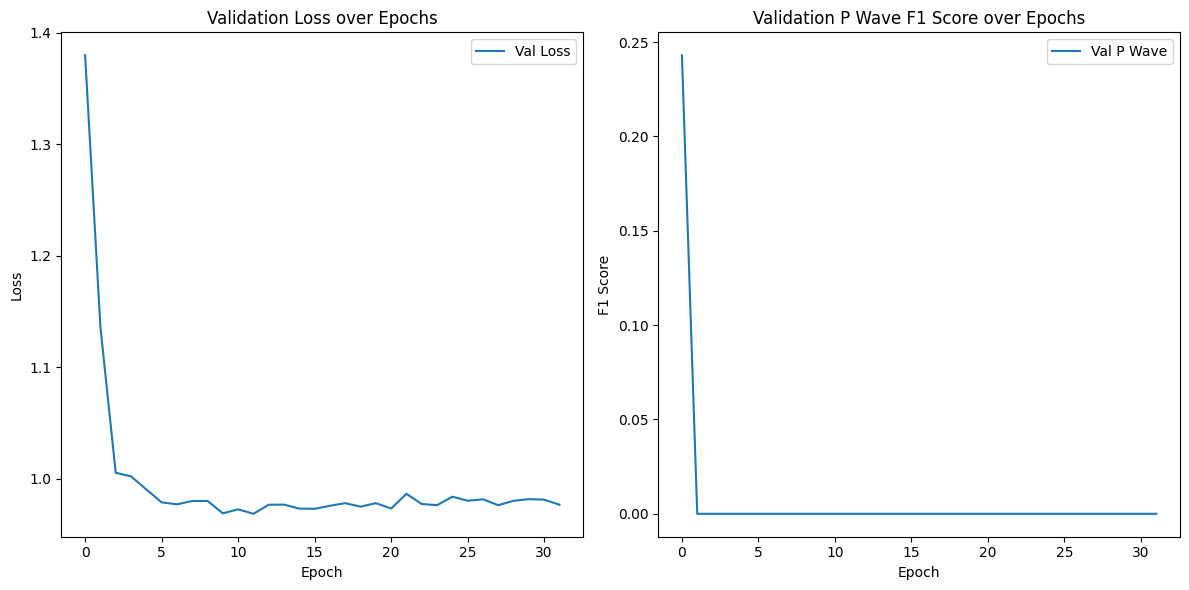

In [118]:
model.plot_metrics()

In [120]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/SegmentationNetwork/epoch=19_val_p_wave=0.000000.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

In [121]:
# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.20202
p_offset: 0.20202
t_onset: 0.28636
t_offset: 0.28130
qrs_onset: 0.90940
qrs_offset: 0.90354
Averaged Short Report: 0.45333


#### 1.4.2 Разработка версии №2. Усложненная full-convolutional сеть с добавлением дополнительных сверточных слоев и слоев пулинга.

В данном разделе интересно было бы проверить предыдущую нейронную сеть с добавлением дополнительных сверточных слоев лои пулинга для увеличения ее способности к извлечению признаков и повышения точности сегментации.

In [125]:
class SegmentationNetworkWithPooling(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(SegmentationNetworkWithPooling, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(128, num_classes, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # Добавляем пулинг со stride=1 и kernel_size=3
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.conv5(x)
        return x

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SegmentationNetworkWithPooling(num_channels, num_classes)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 5000]           1,184
            Conv1d-2             [-1, 64, 5000]           6,208
         MaxPool1d-3             [-1, 64, 5000]               0
            Conv1d-4            [-1, 128, 5000]          24,704
            Conv1d-5            [-1, 128, 5000]          49,280
            Conv1d-6              [-1, 4, 5000]           1,540
Total params: 82,916
Trainable params: 82,916
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.23
Forward/backward pass size (MB): 16.02
Params size (MB): 0.32
Estimated Total Size (MB): 16.57
----------------------------------------------------------------
Inference Time: 0.0023437 seconds


Теперь обучим данную сеть:

In [126]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=150, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                           | Params
---------------------------------------------------------
0 | model | SegmentationNetworkWithPooling | 82.9 K
1 | loss  | CrossEntropyLoss               | 0     
---------------------------------------------------------
82.9 K    Trainable params
0         Non-trainable params
82.9 K    Total params
0.332     Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a

Epoch 0, Val Loss: 1.3984, Val P Wave: 0.3208
Epoch 0, Val Loss: 1.0057, Val P Wave: 0.0000
Epoch 1, Val Loss: 0.9638, Val P Wave: 0.0000
Epoch 2, Val Loss: 0.9525, Val P Wave: 0.0000
Epoch 3, Val Loss: 0.9703, Val P Wave: 0.0000
Epoch 4, Val Loss: 0.9500, Val P Wave: 0.0000
Epoch 5, Val Loss: 0.9531, Val P Wave: 0.0000
Epoch 6, Val Loss: 0.9599, Val P Wave: 0.0000
Epoch 7, Val Loss: 0.9435, Val P Wave: 0.0000
Epoch 8, Val Loss: 0.9670, Val P Wave: 0.0000
Epoch 9, Val Loss: 0.9448, Val P Wave: 0.0000
Epoch 10, Val Loss: 0.9473, Val P Wave: 0.0000
Epoch 11, Val Loss: 0.9413, Val P Wave: 0.0000
Epoch 12, Val Loss: 1.0004, Val P Wave: 0.0000
Epoch 13, Val Loss: 0.9543, Val P Wave: 0.0000
Epoch 14, Val Loss: 0.9586, Val P Wave: 0.0000
Epoch 15, Val Loss: 0.9339, Val P Wave: 0.0000
Epoch 16, Val Loss: 0.9445, Val P Wave: 0.0000
Epoch 17, Val Loss: 0.9195, Val P Wave: 0.0000
Epoch 18, Val Loss: 0.9062, Val P Wave: 0.0000
Epoch 19, Val Loss: 0.9064, Val P Wave: 0.0000
Epoch 20, Val Loss: 0.89

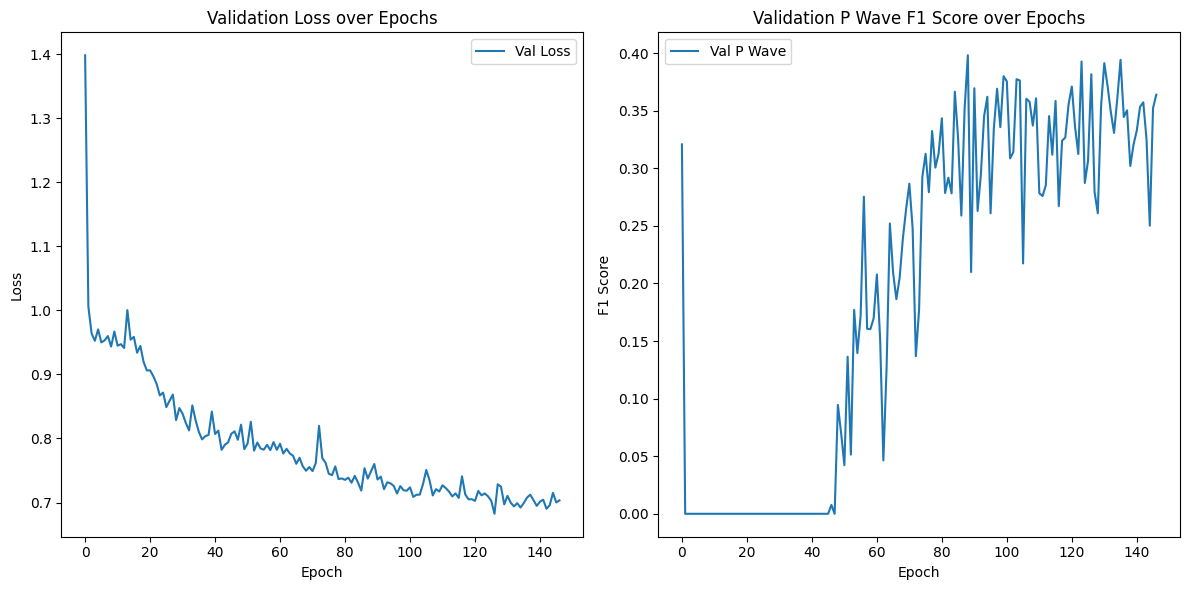

In [134]:
model.plot_metrics()

In [133]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/SegmentationNetworkWithPooling/epoch=134_val_p_wave=0.394236.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.27318
p_offset: 0.33822
t_onset: 0.35002
t_offset: 0.38842
qrs_onset: 0.88469
qrs_offset: 0.91484
Averaged Short Report: 0.48297


Можно заметить как изменились значения наших метрик. Теперь p волна определяется правильно примерно в ~30% случаев, t волна определяется правильно примерно в ~36% случаев, а qrs сегмент на уровне ~90%.

#### 1.4.3 Разработка версии №3. Более глубокая усложненная full-convolutional сеть с добавлением дополнительных сверточных слоев и слоев пулинга.

Давайте добавим еще один блок свертки-пулинга для увеличения глубины и сложности модели. Также мы можем увеличить количество фильтров в каждом сверточном слое для более глубокого извлечения признаков. Вот обновленная версия модели:

In [135]:
class HardSegmentationNetworkWithPooling(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(HardSegmentationNetworkWithPooling, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv7 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv1d(512, num_classes, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.relu(self.conv5(x))
        x = self.pool(x)
        x = torch.relu(self.conv6(x))
        x = self.pool(x)
        x = torch.relu(self.conv7(x))
        x = self.pool(x)
        x = self.conv8(x)
        return x

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = HardSegmentationNetworkWithPooling(num_channels, num_classes).to(device)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           2,368
         MaxPool1d-2             [-1, 64, 5000]               0
            Conv1d-3            [-1, 128, 5000]          24,704
         MaxPool1d-4            [-1, 128, 5000]               0
            Conv1d-5            [-1, 256, 5000]          98,560
         MaxPool1d-6            [-1, 256, 5000]               0
            Conv1d-7            [-1, 512, 5000]         393,728
         MaxPool1d-8            [-1, 512, 5000]               0
            Conv1d-9            [-1, 512, 5000]         786,944
        MaxPool1d-10            [-1, 512, 5000]               0
           Conv1d-11            [-1, 512, 5000]         786,944
        MaxPool1d-12            [-1, 512, 5000]               0
           Conv1d-13   

Натренируем модель:

In [136]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=150, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | HardSegmentationNetworkWithPooling | 2.9 M 
1 | loss  | CrossEntropyLoss                   | 0     
-------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.545    Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To c

Epoch 0, Val Loss: 1.3894, Val P Wave: 0.0880
Epoch 0, Val Loss: 0.9887, Val P Wave: 0.0000
Epoch 1, Val Loss: 0.9169, Val P Wave: 0.0000
Epoch 2, Val Loss: 0.8960, Val P Wave: 0.0000
Epoch 3, Val Loss: 0.8873, Val P Wave: 0.0000
Epoch 4, Val Loss: 0.8681, Val P Wave: 0.0000
Epoch 5, Val Loss: 0.9222, Val P Wave: 0.0000
Epoch 6, Val Loss: 0.8656, Val P Wave: 0.0000
Epoch 7, Val Loss: 0.8844, Val P Wave: 0.0000
Epoch 8, Val Loss: 0.8825, Val P Wave: 0.0000
Epoch 9, Val Loss: 0.8320, Val P Wave: 0.0000
Epoch 10, Val Loss: 0.8351, Val P Wave: 0.0000
Epoch 11, Val Loss: 0.8108, Val P Wave: 0.0000
Epoch 12, Val Loss: 0.7886, Val P Wave: 0.0000
Epoch 13, Val Loss: 0.7648, Val P Wave: 0.0000
Epoch 14, Val Loss: 0.7785, Val P Wave: 0.0000
Epoch 15, Val Loss: 0.7527, Val P Wave: 0.0000
Epoch 16, Val Loss: 0.7588, Val P Wave: 0.0000
Epoch 17, Val Loss: 0.7232, Val P Wave: 0.0000
Epoch 18, Val Loss: 0.7147, Val P Wave: 0.0000
Epoch 19, Val Loss: 0.7118, Val P Wave: 0.0000
Epoch 20, Val Loss: 0.71

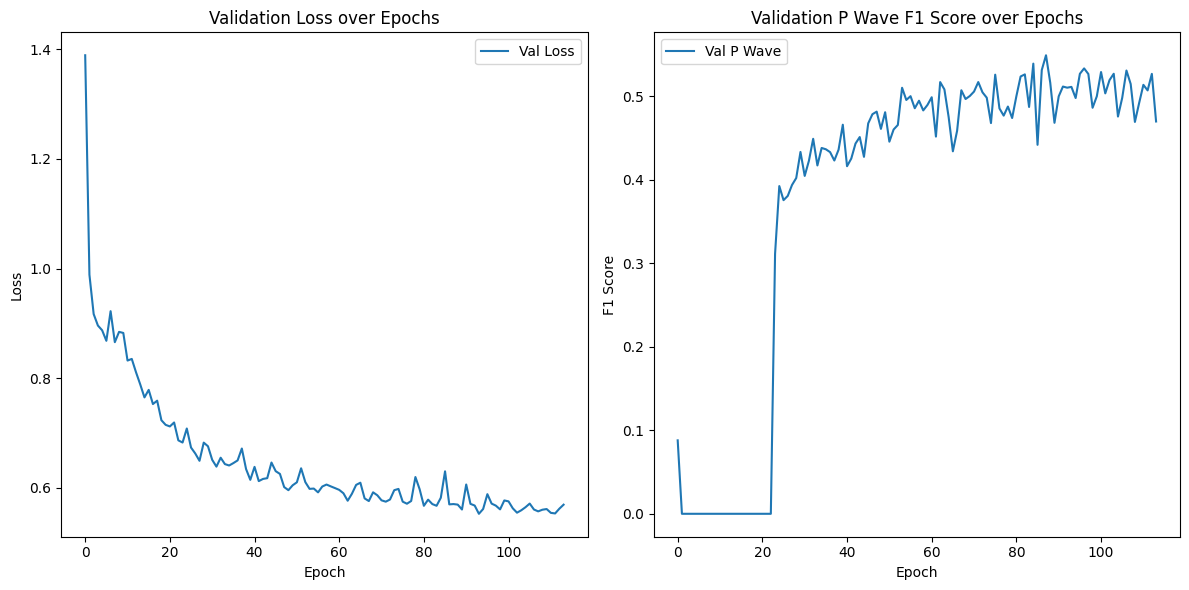

In [137]:
model.plot_metrics()

In [141]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/HardSegmentationNetworkWithPooling/epoch=111_val_p_wave=0.527064.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.33099
p_offset: 0.40915
t_onset: 0.53273
t_offset: 0.56069
qrs_onset: 0.95692
qrs_offset: 0.97314
Averaged Short Report: 0.63035


Метрики показывают, что они улучшились при увеличении глубины сети. Но есть смысл на данном этапе поработать с более сложными архитектурами.

#### 1.4.4 Разработка версии №4. UNet-подобная сеть.

Так как элементарное углубление модели для данной задачи с имеющимся количеством данных не приносит ожидаемых результатов, мы можем привести модель к уже имеющимся архитектурам, которые зарекомендовали себя в задаче сегментаци данных, поэтому ниже произведено приведение нашей модели к Unet-подобной архитектуре, добавив соединения между сверточными слоями и их транспонированными аналогами.

In [142]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()

        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        )

    def forward(self, x):
        # Прямой проход через энкодер
        x1 = self.encoder(x)
        
        # Прямой проход через декодер
        output = self.decoder(x1)
        return output

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SimpleUNet(num_channels, num_classes).to(device)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           2,368
              ReLU-2             [-1, 64, 5000]               0
            Conv1d-3             [-1, 64, 5000]          12,352
              ReLU-4             [-1, 64, 5000]               0
         MaxPool1d-5             [-1, 64, 2500]               0
            Conv1d-6             [-1, 64, 2500]          12,352
              ReLU-7             [-1, 64, 2500]               0
            Conv1d-8              [-1, 4, 2500]             772
              ReLU-9              [-1, 4, 2500]               0
         Upsample-10              [-1, 4, 5000]               0
Total params: 27,844
Trainable params: 27,844
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB):

В данном случае, чтобы исследовать поведение UNet-подобной архитектуры мы начнем с простой версии Unet с одним энкодером и одним декодером. Она включает в себя сверточные слои для энкодера и декодера, а также операцию апсэмплинга для увеличения размера выходного изображения.

Натренируем модель:

In [143]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=150, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | SimpleUNet       | 27.8 K
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
27.8 K    Trainable params
0         Non-trainable params
27.8 K    Total params
0.111     Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

Epoch 0, Val Loss: 1.3736, Val P Wave: 0.1615
Epoch 0, Val Loss: 1.1333, Val P Wave: 0.0000
Epoch 1, Val Loss: 1.0690, Val P Wave: 0.0000
Epoch 2, Val Loss: 1.0661, Val P Wave: 0.0000
Epoch 3, Val Loss: 1.0762, Val P Wave: 0.0000
Epoch 4, Val Loss: 1.0651, Val P Wave: 0.0000
Epoch 5, Val Loss: 1.0640, Val P Wave: 0.0000
Epoch 6, Val Loss: 1.0635, Val P Wave: 0.0000
Epoch 7, Val Loss: 1.0535, Val P Wave: 0.0000
Epoch 8, Val Loss: 1.0659, Val P Wave: 0.0000
Epoch 9, Val Loss: 1.0570, Val P Wave: 0.0000
Epoch 10, Val Loss: 1.0549, Val P Wave: 0.0000
Epoch 11, Val Loss: 1.0500, Val P Wave: 0.0000
Epoch 12, Val Loss: 1.0486, Val P Wave: 0.0000
Epoch 13, Val Loss: 1.0506, Val P Wave: 0.0000
Epoch 14, Val Loss: 1.0486, Val P Wave: 0.0000
Epoch 15, Val Loss: 1.0476, Val P Wave: 0.0000
Epoch 16, Val Loss: 1.0387, Val P Wave: 0.0000
Epoch 17, Val Loss: 1.0299, Val P Wave: 0.0000
Epoch 18, Val Loss: 1.0214, Val P Wave: 0.0000
Epoch 19, Val Loss: 1.0150, Val P Wave: 0.0000
Epoch 20, Val Loss: 1.01

Результаты метрик на тестовых данных:

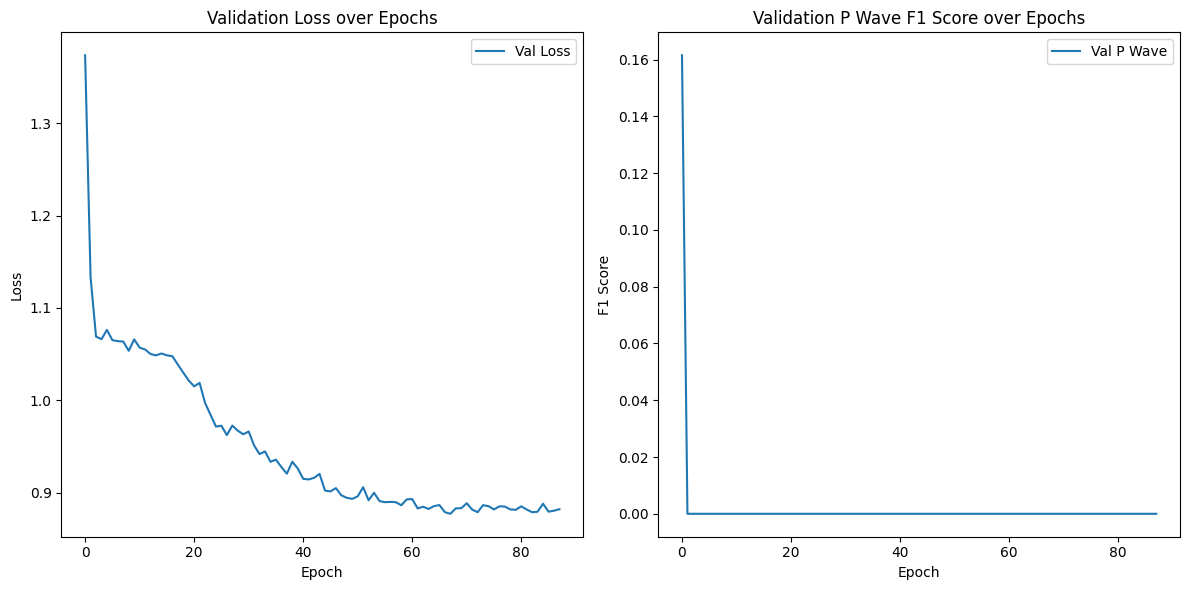

In [144]:
model.plot_metrics()

In [145]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/SimpleUNet/epoch=19_val_p_wave=0.000000.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.20202
p_offset: 0.20202
t_onset: 0.00000
t_offset: 0.00000
qrs_onset: 0.82109
qrs_offset: 0.81271
Averaged Short Report: 0.47493


Можно заметить, что метрики хуже, чем версия с усложненной версии full-convolutional сетью. Проблема в том, что сеть, которая реализована выше, состоит из двух сверточных слоев в энкодере и двух в декодере, что может быть недостаточно для эффективной сегментации сложных данных, таких как сигналы ЭКГ. Важно учитывать, что для успешной сегментации требуются глубокие и сложные архитектуры сетей, способные улавливать различные уровни признаков в данных.

#### 1.4.5 Разработка версии №5. Усложненная UNet-подобная сеть.

In [21]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [146]:
class UNetDecoder(nn.Module):
    def __init__(self):
        super(UNetDecoder, self).__init__()
        # Увеличиваем размер с 2500 до 5000 и количество каналов с 128 до 64
        self.upconv1 = nn.ConvTranspose1d(128, 64, kernel_size=8, stride=4, padding=2)
        # Сверточные слои после конкатенации
        self.conv1 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        # Выходной слой, предполагая что нужно num_classes каналов на выходе
        self.final_conv = nn.Conv1d(64, num_classes, kernel_size=3, padding=1)

    def forward(self, x, skips):
        # Применяем апсемплинг
        x = self.upconv1(x)  # x теперь [2, 64, 5000]
        # Конкатенация с соответствующим слоем из skips
        x = torch.cat((x, skips[0]), dim=1)  # x теперь [2, 128, 5000]
        # Применяем сверточные слои
        x = self.conv1(x)
        # Применяем выходной слой
        x = self.final_conv(x)  # x теперь [2, num_classes, 5000]
        return x

class ImprovedUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedUNet, self).__init__()
        
        self.encoder = nn.ModuleList([
            nn.Sequential(nn.Conv1d(in_channels, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm1d(64)),
            nn.MaxPool1d(2),  # Уменьшает размерность в 2 раза
            nn.Sequential(nn.Conv1d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm1d(128)),
            nn.MaxPool1d(2)   # Уменьшает размерность в 2 раза
        ])

        self.decoder = UNetDecoder()
    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            if isinstance(layer, nn.Sequential):
                skips.append(x)
        x = self.decoder(x, skips) 
        return x

# Создадим модель
model = ImprovedUNet(in_channels=12, out_channels=4).to(device)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           2,368
              ReLU-2             [-1, 64, 5000]               0
       BatchNorm1d-3             [-1, 64, 5000]             128
         MaxPool1d-4             [-1, 64, 2500]               0
            Conv1d-5            [-1, 128, 2500]          24,704
              ReLU-6            [-1, 128, 2500]               0
       BatchNorm1d-7            [-1, 128, 2500]             256
         MaxPool1d-8            [-1, 128, 1250]               0
   ConvTranspose1d-9             [-1, 64, 5000]          65,600
           Conv1d-10             [-1, 64, 5000]          24,640
             ReLU-11             [-1, 64, 5000]               0
      BatchNorm1d-12             [-1, 64, 5000]             128
           Conv1d-13   

Давайте разберемся в этом коде:
1. Энкодер: Он состоит из последовательности сверточных слоев и слоев максимального пулинга, которые уменьшают размерность входных данных вдоль оси длины сигнала.
2. Декодер: Он состоит из слоев транспонированной свертки и слоев двойной свертки. Важно отметить, что каждый выход из слоя энкодера используется для соединения с соответствующим слоем декодера в процессе декодирования.
3. Проход через декодер: В цикле for происходит перебор слоев декодера. В каждой итерации, если индекс i четный, то происходит объединение выхода из текущего слоя декодера с соответствующим выходом из энкодера. Затем, через текущий слой декодера пропускается объединенный тензор.
4. cropped_encoder_output: Для каждого четного слоя декодера выбирается соответствующий выход из энкодера, который затем обрезается до размера выхода из декодера перед объединением.  
5. Возвращаемый результат: Возвращается выход из последнего слоя декодера, который представляет собой предсказание модели.

In [147]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=150, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ImprovedUNet     | 118 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.474     Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

Epoch 0, Val Loss: 1.3515, Val P Wave: 0.0000
Epoch 0, Val Loss: 1.1000, Val P Wave: 0.0000
Epoch 1, Val Loss: 0.9526, Val P Wave: 0.0000
Epoch 2, Val Loss: 0.9247, Val P Wave: 0.0000
Epoch 3, Val Loss: 0.8279, Val P Wave: 0.0000
Epoch 4, Val Loss: 0.9121, Val P Wave: 0.0000
Epoch 5, Val Loss: 0.8262, Val P Wave: 0.0000
Epoch 6, Val Loss: 0.8048, Val P Wave: 0.0000
Epoch 7, Val Loss: 0.8057, Val P Wave: 0.0000
Epoch 8, Val Loss: 0.8338, Val P Wave: 0.0000
Epoch 9, Val Loss: 0.8249, Val P Wave: 0.0000
Epoch 10, Val Loss: 0.8150, Val P Wave: 0.0000
Epoch 11, Val Loss: 0.7716, Val P Wave: 0.0000
Epoch 12, Val Loss: 0.7591, Val P Wave: 0.0740
Epoch 13, Val Loss: 0.7490, Val P Wave: 0.0396
Epoch 14, Val Loss: 0.7804, Val P Wave: 0.2444
Epoch 15, Val Loss: 0.7662, Val P Wave: 0.2318
Epoch 16, Val Loss: 0.7505, Val P Wave: 0.2622
Epoch 17, Val Loss: 0.7383, Val P Wave: 0.3051
Epoch 18, Val Loss: 0.7757, Val P Wave: 0.2436
Epoch 19, Val Loss: 0.6996, Val P Wave: 0.3453
Epoch 20, Val Loss: 0.70

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149, Val Loss: 0.5637, Val P Wave: 0.3773


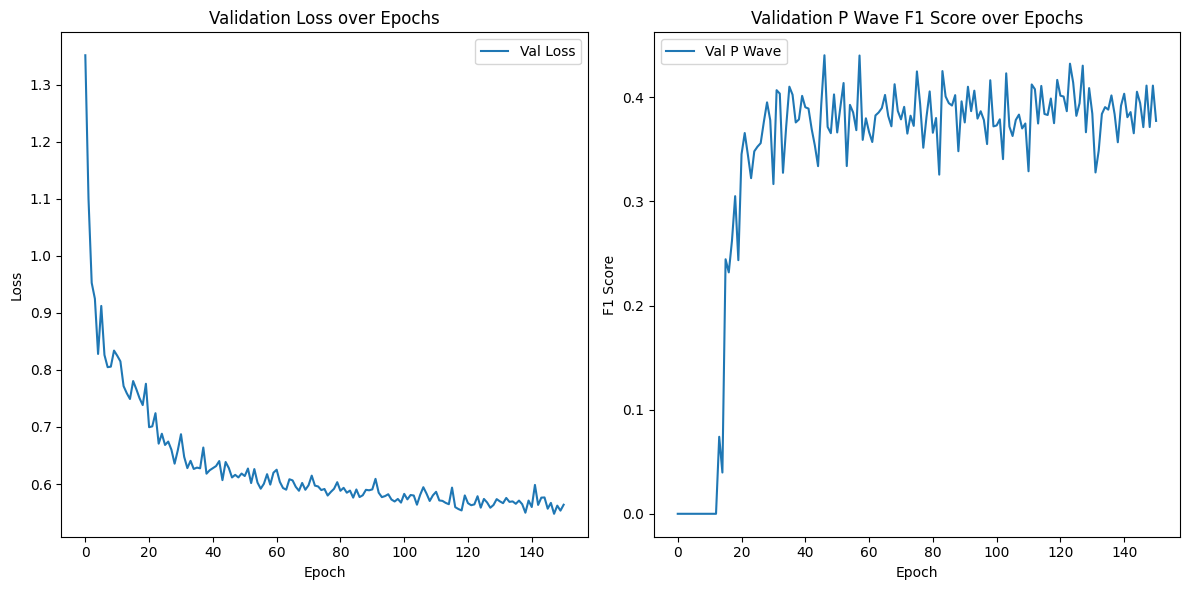

In [148]:
model.plot_metrics()

In [149]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/ImprovedUNet/epoch=148_val_p_wave=0.411236.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.31331
p_offset: 0.36360
t_onset: 0.38520
t_offset: 0.40369
qrs_onset: 0.89767
qrs_offset: 0.93579
Averaged Short Report: 0.48700


Можно заметить, что результаты метрики увеличились непосредственно с усложнением UNet-а. Но UNet давно изученная модель в использовании относительно задачи сегментации ЭКГ. Давайте рассмотрим для нашей задачи другие сегментационные модели.

Для задач сегментации изображений существует множество архитектур нейронных сетей, каждая из которых имеет свои особенности и применяется в зависимости от специфики задачи. Вот несколько популярных архитектур:

1. **UNet**: Одна из самых популярных архитектур для медицинской сегментации. Она использует скип-соединения для передачи информации между слоями энкодера и декодера, что помогает сохранить пространственную информацию при восстановлении изображения.  
2. **SegNet**: Архитектура, похожая на UNet, с акцентом на использование индексов максимального пулинга из энкодера для нелинейной деиндексации в декодере. Это позволяет более эффективно использовать пространственные признаки при меньшем количестве параметров.  
3. **DeepLab (v3 и v3+)**: Использует атроус свертки (dilated convolutions) для увеличения поля зрения сверточных слоев, а также включает ASPP (Atrous Spatial Pyramid Pooling), что позволяет захватывать контекст на нескольких масштабах. DeepLabv3+ добавляет к этому еще и улучшенный декодер для уточнения границ объектов.  
4. **Mask R-CNN**: Расширение Faster R-CNN, добавляющее ветвь для предсказания масок на каждый ROI, позволяя проводить сегментацию на уровне экземпляра. Это хорошо подходит для задач, где необходимо различать отдельные объекты одного класса.  
5. **PSPNet (Pyramid Scene Parsing Network)**: Использует пирамиду глобального пулинга для улавливания информации на различных масштабах. Это особенно полезно для сцен анализа, где контекст важен для точной сегментации.  
6. **RefineNet**: Сеть для мультипатового рафинирования, которая использует информацию из всех уровней глубины для улучшения качества сегментации. Эта архитектура направлена на использование информации с высоким разрешением на всех этапах обработки.  
7. **LinkNet**: Основана на идее эффективного использования энкодера, предназначенного для классификации (например, ResNet) с добавлением декодера, который восстанавливает размерность изображения, используя скип-соединения для улучшения точности.  
8. **HRNet (High-Resolution Network)**: Уникально сочетает высокое разрешение с возможностями углубленного анализа через сеть, сохраняя высокое разрешение через все слои сети.  
Эти архитектуры подходят для различных видов сегментационных задач и выбор конкретной архитектуры зависит от специфических требований приложения, доступности вычислительных ресурсов и требуемой точности.  
**UNet мы опробовали, есть смысл протестировать несколько архитектур из этого списка в качестве экспериментов.**

#### 1.4.6. Разработка SegNet.

Для построения архитектуры SegNet, адаптированной под нашу задачу сегментации сигналов, мы можем воспользоваться модификацией стандартного подхода SegNet для работы с 1D данными, поскольку большинство стандартных реализаций SegNet предназначены для работы с изображениями (2D данных).

В этом случае, основная идея заключается в использовании 1D сверточных слоев вместо 2D, и адаптации слоев пулинга и апсемплинга для работы с одномерными данными.

In [150]:
class SegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)
        
        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices2)
        x = self.decoder_conv1(x)
        
        x = self.decoder_unpool2(x, indices1)
        x = self.decoder_conv2(x)
        
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = SegNet1D(input_channels, output_channels).to(device)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           5,440
       BatchNorm1d-2             [-1, 64, 5000]             128
              ReLU-3             [-1, 64, 5000]               0
         MaxPool1d-4  [[-1, 64, 2500], [-1, 64, 2500]]               0
            Conv1d-5            [-1, 128, 2500]          57,472
       BatchNorm1d-6            [-1, 128, 2500]             256
              ReLU-7            [-1, 128, 2500]               0
         MaxPool1d-8  [[-1, 128, 1250], [-1, 128, 1250]]               0
       MaxUnpool1d-9            [-1, 128, 2500]               0
           Conv1d-10             [-1, 64, 2500]          57,408
      BatchNorm1d-11             [-1, 64, 2500]             128
             ReLU-12             [-1, 64, 2500]               0
      M

##### Ключевые особенности:
**1D сверточные слои**: Позволяют обрабатывать временные ряды или одномерные сигналы.  
**MaxPool1d с return_indices**: Это позволяет в процессе пулинга сохранять индексы максимальных значений, которые затем используются в слое MaxUnpool1d для восстановления данных до исходного размера.  
**MaxUnpool1d**: Используется для апсемплинга данных в декодере, возвращая значения в исходные позиции на основе сохраненных индексов.  
Этот подход позволяет модели эффективно учиться на данных, представляющих собой одномерные сигналы, и проводить сегментацию, восстанавливая исходные размеры выходных данных для каждого класса.  

Теперь натренируем модель:

In [152]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=250, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | SegNet1D         | 122 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

Epoch 0, Val Loss: 0.7833, Val P Wave: 0.4269
Epoch 0, Val Loss: 0.7560, Val P Wave: 0.3374
Epoch 1, Val Loss: 0.8082, Val P Wave: 0.3659
Epoch 2, Val Loss: 0.7140, Val P Wave: 0.4565
Epoch 3, Val Loss: 0.7273, Val P Wave: 0.3825
Epoch 4, Val Loss: 0.7678, Val P Wave: 0.2748
Epoch 5, Val Loss: 0.6751, Val P Wave: 0.5056
Epoch 6, Val Loss: 0.7457, Val P Wave: 0.3464
Epoch 7, Val Loss: 0.7146, Val P Wave: 0.3982
Epoch 8, Val Loss: 0.6919, Val P Wave: 0.4311
Epoch 9, Val Loss: 0.6825, Val P Wave: 0.4515
Epoch 10, Val Loss: 0.7814, Val P Wave: 0.3494
Epoch 11, Val Loss: 0.6588, Val P Wave: 0.4248
Epoch 12, Val Loss: 0.7002, Val P Wave: 0.5354
Epoch 13, Val Loss: 0.6550, Val P Wave: 0.4325
Epoch 14, Val Loss: 0.6599, Val P Wave: 0.4042
Epoch 15, Val Loss: 0.6796, Val P Wave: 0.3268
Epoch 16, Val Loss: 0.6133, Val P Wave: 0.4482
Epoch 17, Val Loss: 0.7021, Val P Wave: 0.4539
Epoch 18, Val Loss: 0.6344, Val P Wave: 0.4714
Epoch 19, Val Loss: 0.6889, Val P Wave: 0.3874
Epoch 20, Val Loss: 0.61

Результаты метрик на тестовых данных:

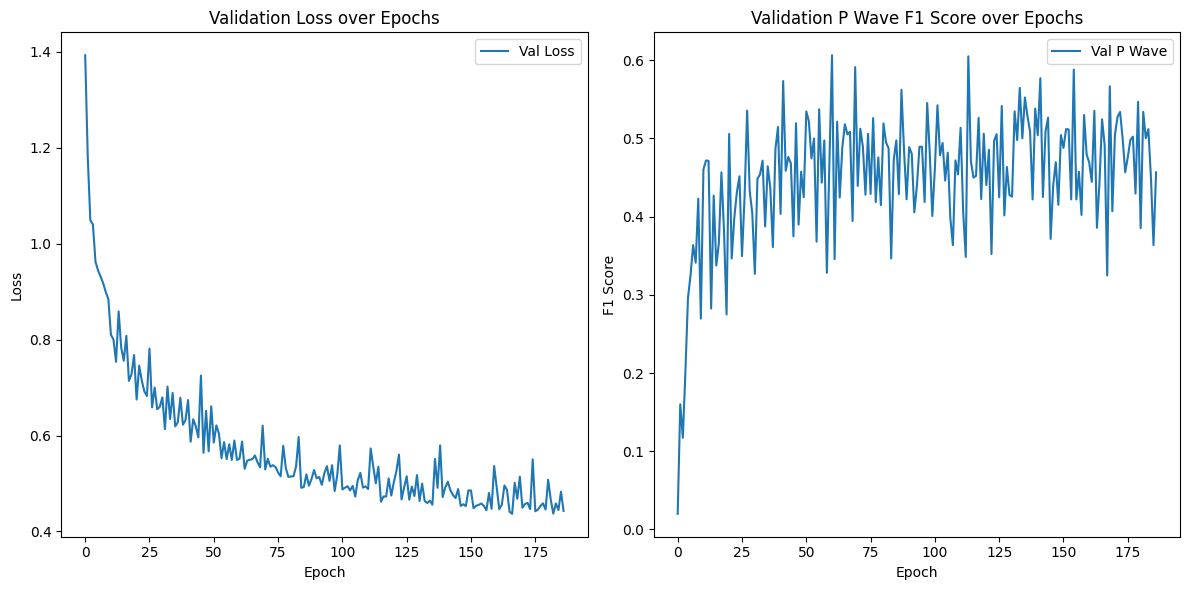

In [153]:
model.plot_metrics()

In [156]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/SegNet1D/epoch=164_val_p_wave=0.546654.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.45440
p_offset: 0.54512
t_onset: 0.51638
t_offset: 0.50484
qrs_onset: 0.95368
qrs_offset: 0.96911
Averaged Short Report: 0.60937


Модель показала неплохие результаты для такой небольшой глубины, можем попробовать усложнить эту сеть.

#### 1.4.6. Разработка улучшенного SegNet.

Для улучшения производительности и точности сегментации в модели SegNet для одномерных данных, мы можем внести несколько изменений, направленных на улучшение изучения признаков и увеличение глубины сети. Это включает добавление дополнительных слоев, увеличение количества каналов в сверточных слоях, а также внедрение дополнительных элементов, таких как Dropout для предотвращения переобучения.

In [157]:
class AdvancedSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(AdvancedSegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)
        
        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        x, indices3 = self.encoder_pool3(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices3)
        x = self.decoder_conv1(x)
        
        x = self.decoder_unpool2(x, indices2)
        x = self.decoder_conv2(x)

        x = self.decoder_unpool3(x, indices1)
        x = self.decoder_conv3(x)
        
        return x


# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = AdvancedSegNet1D(input_channels, output_channels).to(device)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           5,440
       BatchNorm1d-2             [-1, 64, 5000]             128
              ReLU-3             [-1, 64, 5000]               0
            Conv1d-4             [-1, 64, 5000]          28,736
       BatchNorm1d-5             [-1, 64, 5000]             128
              ReLU-6             [-1, 64, 5000]               0
         MaxPool1d-7  [[-1, 64, 2500], [-1, 64, 2500]]               0
            Conv1d-8            [-1, 128, 2500]          57,472
       BatchNorm1d-9            [-1, 128, 2500]             256
             ReLU-10            [-1, 128, 2500]               0
           Conv1d-11            [-1, 128, 2500]         114,816
      BatchNorm1d-12            [-1, 128, 2500]             256
             ReL

##### Ключевые особенности и улучшения:
**Больше сверточных слоев**: Каждый блок свертки теперь содержит два сверточных слоя, что позволяет извлекать более сложные признаки на каждом уровне.  
**Увеличенное количество фильтров**: Увеличение количества каналов в сверточных слоях помогает сети обучаться на более сложной иерархии признаков.  
**Больше уровней глубины**: Добавление дополнительного уровня глубины в энкодер и декодер улучшает способность сети восстанавливать детализированные сегментации.  
Эти изменения направлены на улучшение способности модели извлекать сложные признаки из данных и более точно восстанавливать детали в процессе сегментации, что потенциально приведет к улучшению точности сегментации.  

In [158]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=250, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | AdvancedSegNet1D | 1.8 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.158     Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

Epoch 0, Val Loss: 1.3863, Val P Wave: 0.0247
Epoch 0, Val Loss: 1.0577, Val P Wave: 0.0538
Epoch 1, Val Loss: 0.9595, Val P Wave: 0.0885
Epoch 2, Val Loss: 0.8408, Val P Wave: 0.1159
Epoch 3, Val Loss: 0.8493, Val P Wave: 0.0667
Epoch 4, Val Loss: 0.7850, Val P Wave: 0.2991
Epoch 5, Val Loss: 0.6881, Val P Wave: 0.6437
Epoch 6, Val Loss: 0.7032, Val P Wave: 0.6695
Epoch 7, Val Loss: 0.6856, Val P Wave: 0.7003
Epoch 8, Val Loss: 0.6903, Val P Wave: 0.6630
Epoch 9, Val Loss: 0.6572, Val P Wave: 0.7011
Epoch 10, Val Loss: 0.6924, Val P Wave: 0.6526
Epoch 11, Val Loss: 0.6229, Val P Wave: 0.7340
Epoch 12, Val Loss: 0.6309, Val P Wave: 0.7472
Epoch 13, Val Loss: 0.6206, Val P Wave: 0.7410
Epoch 14, Val Loss: 0.6313, Val P Wave: 0.7087
Epoch 15, Val Loss: 0.6127, Val P Wave: 0.7022
Epoch 16, Val Loss: 0.5769, Val P Wave: 0.7584
Epoch 17, Val Loss: 0.5957, Val P Wave: 0.7076
Epoch 18, Val Loss: 0.5795, Val P Wave: 0.7243
Epoch 19, Val Loss: 0.5537, Val P Wave: 0.7731
Epoch 20, Val Loss: 0.56

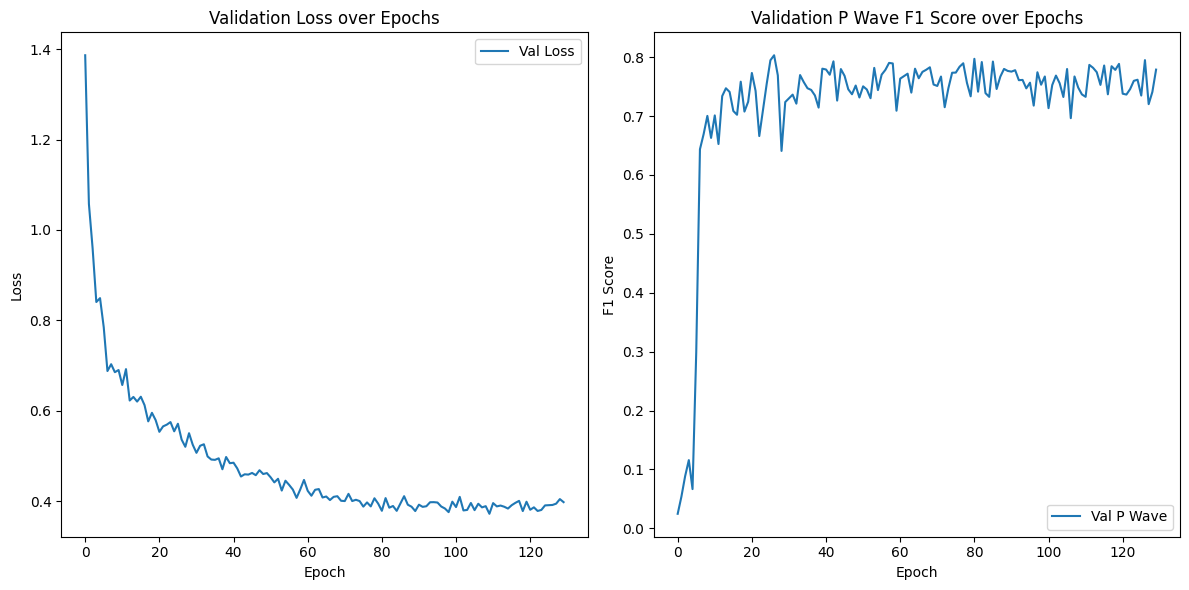

In [159]:
model.plot_metrics()

Результаты метрик на тестовых данных:

In [173]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/AdvancedSegNet1D/epoch=81_val_p_wave=0.791744.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.66430
p_offset: 0.67006
t_onset: 0.82908
t_offset: 0.84115
qrs_onset: 0.99873
qrs_offset: 0.99912
Averaged Short Report: 0.85287


#### 1.4.6. Разработка улучшенного SegNet с добавлением дополнительных сверточных слоев.

Предыдущая модель показала неплохие результаты, мы можем попробовать увеличить глубину сети.

In [184]:
class DeeperAdvancedSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DeeperAdvancedSegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool4 = nn.MaxPool1d(2, return_indices=True)

        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool4 = nn.MaxUnpool1d(2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        size1 = x.size()
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        size2 = x.size()
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        size3 = x.size()
        x, indices3 = self.encoder_pool3(x)

        x = self.encoder_conv4(x)
        size4 = x.size()
        x, indices4 = self.encoder_pool4(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices4, output_size=size4)
        x = self.decoder_conv1(x)
        
        x = self.decoder_unpool2(x, indices3, output_size=size3)
        x = self.decoder_conv2(x)

        x = self.decoder_unpool3(x, indices2, output_size=size2)
        x = self.decoder_conv3(x)

        x = self.decoder_unpool4(x, indices1, output_size=size1)
        x = self.decoder_conv4(x)
        
        return x


# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeeperAdvancedSegNet1D(input_channels, output_channels).to(device)

print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           5,440
       BatchNorm1d-2             [-1, 64, 5000]             128
              ReLU-3             [-1, 64, 5000]               0
            Conv1d-4             [-1, 64, 5000]          28,736
       BatchNorm1d-5             [-1, 64, 5000]             128
              ReLU-6             [-1, 64, 5000]               0
         MaxPool1d-7  [[-1, 64, 2500], [-1, 64, 2500]]               0
            Conv1d-8            [-1, 128, 2500]          57,472
       BatchNorm1d-9            [-1, 128, 2500]             256
             ReLU-10            [-1, 128, 2500]               0
           Conv1d-11            [-1, 128, 2500]         114,816
      BatchNorm1d-12            [-1, 128, 2500]             256
             ReL

In [185]:
# Тренировка модели
now = datetime.now().strftime('%d.%m.%Y_%H:%M:%S')
checkpoint = ModelCheckpoint(dirpath=f'hdd/models_{now}',
                             filename='{epoch}_{val_p_wave:.6f}',
                             monitor='val_p_wave',
                             save_top_k=20,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20)

trainer = Trainer(max_epochs=250, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DeeperAdvancedSegNet1D | 7.3 M 
1 | loss  | CrossEntropyLoss       | 0     
-------------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.199    Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a tensor, it is recommended to use source

Epoch 0, Val Loss: 1.3729, Val P Wave: 0.0000
Epoch 0, Val Loss: 0.9728, Val P Wave: 0.6051
Epoch 1, Val Loss: 0.7718, Val P Wave: 0.6407
Epoch 2, Val Loss: 0.7447, Val P Wave: 0.7526
Epoch 3, Val Loss: 0.7083, Val P Wave: 0.7901
Epoch 4, Val Loss: 0.6952, Val P Wave: 0.8348
Epoch 5, Val Loss: 0.6746, Val P Wave: 0.7992
Epoch 6, Val Loss: 0.6399, Val P Wave: 0.8348
Epoch 7, Val Loss: 0.6799, Val P Wave: 0.7620
Epoch 8, Val Loss: 0.6193, Val P Wave: 0.8538
Epoch 9, Val Loss: 0.6146, Val P Wave: 0.8462
Epoch 10, Val Loss: 0.6009, Val P Wave: 0.8551
Epoch 11, Val Loss: 0.5872, Val P Wave: 0.8818
Epoch 12, Val Loss: 0.5750, Val P Wave: 0.8725
Epoch 13, Val Loss: 0.5671, Val P Wave: 0.8814
Epoch 14, Val Loss: 0.5557, Val P Wave: 0.8699
Epoch 15, Val Loss: 0.5509, Val P Wave: 0.8621
Epoch 16, Val Loss: 0.5490, Val P Wave: 0.8805
Epoch 17, Val Loss: 0.5285, Val P Wave: 0.8638
Epoch 18, Val Loss: 0.5257, Val P Wave: 0.8664
Epoch 19, Val Loss: 0.5108, Val P Wave: 0.8944
Epoch 20, Val Loss: 0.51

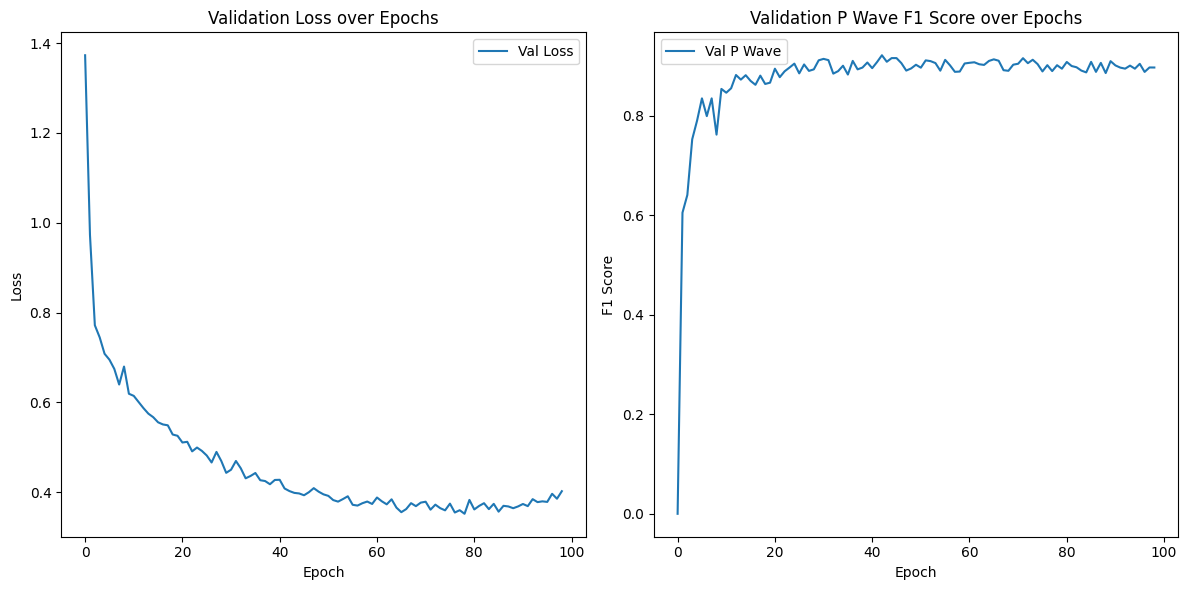

In [186]:
model.plot_metrics()

Результаты метрик на тестовой выборке:

In [191]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/DeeperAdvancedSegNet1D/epoch=41_val_p_wave=0.921450.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.80060
p_offset: 0.80728
t_onset: 0.96297
t_offset: 0.96157
qrs_onset: 0.99941
qrs_offset: 0.99809
Averaged Short Report: 0.95320


Можем видеть, что теперь метрики стали еще выше, расположение p-волны правильно сегментируется в 80% случаев, t-волны примерно в 96% случаев, а qrs сегмента в 99% случаев. Однако последующее увеличение глубины сети скорее всего не покажет метрики сильно выше этих, но сильно утежелит модель, что повлияет на ее быстродействие и скорость обученик, поэтому предлагается попробовать другие способы увеличения точности сегментации.

#### 1.4.7. Разработка улучшенного SegNet с добавлением механизма влияния.

Для дальнейшего улучшения качества сегментации, одним из эффективных подходов может быть внедрение механизма внимания или "attention", который помогает сети фокусироваться на наиболее информативных частях входных данных. Это может особенно хорошо работать в задачах, где не все части входных данных одинаково важны для определения класса каждой точки данных.  

##### Добавление Attention механизма  
Мы можем добавить простой self-attention механизм в вашу модель. Это можно сделать путём внедрения специального attention слоя, который будет учитывать веса каждого канала в данных после каждого блока декодирования. Этот подход позволит модели уделять больше внимания важным признакам.  

##### Реализация Channel Attention  
Один из простых и эффективных способов внедрения attention — использование channel attention, который фокусируется на важности каждого канала. Простой способ реализации — использовать global average pooling для получения средних значений по каждому каналу, затем применить полносвязный слой для расчёта весов каналов, и, наконец, умножить исходные каналы на вычисленные веса.  

In [98]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_channels // reduction_ratio, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c) 
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class AttentionSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(AttentionSegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool4 = nn.MaxPool1d(2, return_indices=True)

        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 256, kernel_size=8, padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool4 = nn.MaxUnpool1d(2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

        # Внедрение модуля внимания
        self.attention1 = ChannelAttentionModule(256)
        self.attention2 = ChannelAttentionModule(128)
        self.attention3 = ChannelAttentionModule(64)

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        x, indices3 = self.encoder_pool3(x)

        x = self.encoder_conv4(x)
        x, indices4 = self.encoder_pool4(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices4)
        x = self.decoder_conv1(x)
        x = self.attention1(x)
        
        x = self.decoder_unpool2(x, indices3)
        x = self.decoder_conv2(x)
        x = self.attention2(x)
        
        x = self.decoder_unpool3(x, indices2)
        x = self.decoder_conv3(x)
        x = self.attention3(x)
        
        x = self.decoder_unpool4(x, indices1)
        x = self.decoder_conv4(x)
       
        
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = AttentionSegNet1D(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           5,440
       BatchNorm1d-2             [-1, 64, 5000]             128
              ReLU-3             [-1, 64, 5000]               0
            Conv1d-4             [-1, 64, 5000]          28,736
       BatchNorm1d-5             [-1, 64, 5000]             128
              ReLU-6             [-1, 64, 5000]               0
         MaxPool1d-7  [[-1, 64, 2500], [-1, 64, 2500]]               0
            Conv1d-8            [-1, 128, 2500]          57,472
       BatchNorm1d-9            [-1, 128, 2500]             256
             ReLU-10            [-1, 128, 2500]               0
           Conv1d-11            [-1, 128, 2500]         114,816
      BatchNorm1d-12            [-1, 128, 2500]             256
             ReL

Эта модификация позволяет улучшить способность модели к фокусировке на ключевых признаках, что может повысить точность сегментации, особенно в сложных условиях или при наличии шума в данных.

In [99]:
# Тренировка модели
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.8968825608129926
Epoch 1/100, Validation Loss: 0.7872986899268243
Epoch 2/100, Training Loss: 0.6993828277114914
Epoch 2/100, Validation Loss: 0.605374411709847
Epoch 3/100, Training Loss: 0.6130962761548849
Epoch 3/100, Validation Loss: 0.5347305372838052
Epoch 4/100, Training Loss: 0.5535463012664424
Epoch 4/100, Validation Loss: 0.5081355653462871
Epoch 5/100, Training Loss: 0.5121886475607451
Epoch 5/100, Validation Loss: 0.4691997977995103
Epoch 6/100, Training Loss: 0.4874200635110801
Epoch 6/100, Validation Loss: 0.4588422035017321
Epoch 7/100, Training Loss: 0.460272544550027
Epoch 7/100, Validation Loss: 0.4345672553585422
Epoch 8/100, Training Loss: 0.4457284062497529
Epoch 8/100, Validation Loss: 0.40545741540770375
Epoch 9/100, Training Loss: 0.4256325429267729
Epoch 9/100, Validation Loss: 0.39701217869597094
Epoch 10/100, Training Loss: 0.4183274105734188
Epoch 10/100, Validation Loss: 0.3975501166236016
Epoch 11/100, Training Loss: 0.4006713

In [100]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.83115
p_offset: 0.82901
t_onset: 0.87987
t_offset: 0.87111
qrs_onset: 0.96081
qrs_offset: 0.95714


Можем заметить, что attention механизм действительно помог улучшить определение t волны, на данный момент она определяется с точностью примерно в 87%. P волна определяется с точностью 83%, qrs сегмент с точностью 96%. Попробуем интегрировать дополнительные алгоритмы для повышения точности сегментации.

#### 1.4.8. Разработка SegNet с добавлением механизма влияния и остаточными блоками.

Для дальнейшего повышения эффективности модели можно рассмотреть добавление дополнительных усовершенствований, таких как использование глубоких остаточных блоков (deep residual blocks).  

Остаточные блоки (Residual Blocks) могут помочь уменьшить проблему исчезающих градиентов в глубоких сетях, улучшая обучение и способность сети к извлечению сложных признаков без потери информации на промежуточных слоях.

In [101]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResAttentionSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ResAttentionSegNet1D, self).__init__()
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool4 = nn.MaxPool1d(2, return_indices=True)

        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 256, kernel_size=8, padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool4 = nn.MaxUnpool1d(2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

        # Внедрение модуля внимания
        self.attention1 = ChannelAttentionModule(256)
        self.attention2 = ChannelAttentionModule(128)
        self.attention3 = ChannelAttentionModule(64)
        
        # Добавление остаточных блоков
        self.res_block1 = ResidualBlock(256)
        self.res_block2 = ResidualBlock(128)
        self.res_block3 = ResidualBlock(64)

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        x, indices3 = self.encoder_pool3(x)

        x = self.encoder_conv4(x)
        x, indices4 = self.encoder_pool4(x)

        # Декодер с остаточными блоками
        x = self.decoder_unpool1(x, indices4)
        x = self.decoder_conv1(x)
        x = self.res_block1(x)  # Применение остаточного блока
        x = self.attention1(x)
        
        x = self.decoder_unpool2(x, indices3)
        x = self.decoder_conv2(x)
        x = self.res_block2(x)
        x = self.attention2(x)
        
        x = self.decoder_unpool3(x, indices2)
        x = self.decoder_conv3(x)
        x = self.res_block3(x)
        x = self.attention3(x)
        
        x = self.decoder_unpool4(x, indices1)
        x = self.decoder_conv4(x)
        
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = ResAttentionSegNet1D(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           5,440
       BatchNorm1d-2             [-1, 64, 5000]             128
              ReLU-3             [-1, 64, 5000]               0
            Conv1d-4             [-1, 64, 5000]          28,736
       BatchNorm1d-5             [-1, 64, 5000]             128
              ReLU-6             [-1, 64, 5000]               0
         MaxPool1d-7  [[-1, 64, 2500], [-1, 64, 2500]]               0
            Conv1d-8            [-1, 128, 2500]          57,472
       BatchNorm1d-9            [-1, 128, 2500]             256
             ReLU-10            [-1, 128, 2500]               0
           Conv1d-11            [-1, 128, 2500]         114,816
      BatchNorm1d-12            [-1, 128, 2500]             256
             ReL

In [102]:
# Тренировка модели
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.9279591730731701
Epoch 1/100, Validation Loss: 0.8127460575872852
Epoch 2/100, Training Loss: 0.7798083670708814
Epoch 2/100, Validation Loss: 0.7134575507333202
Epoch 3/100, Training Loss: 0.6481134264092696
Epoch 3/100, Validation Loss: 0.5522382100743632
Epoch 4/100, Training Loss: 0.5645432764219369
Epoch 4/100, Validation Loss: 0.505205441386469
Epoch 5/100, Training Loss: 0.5199967928019612
Epoch 5/100, Validation Loss: 0.4849419944709347
Epoch 6/100, Training Loss: 0.4919208184427578
Epoch 6/100, Validation Loss: 0.45181229374101084
Epoch 7/100, Training Loss: 0.47216953475948287
Epoch 7/100, Validation Loss: 0.42374066095198354
Epoch 8/100, Training Loss: 0.44148505421785206
Epoch 8/100, Validation Loss: 0.42298857723512956
Epoch 9/100, Training Loss: 0.42766312090491476
Epoch 9/100, Validation Loss: 0.3891171697647341
Epoch 10/100, Training Loss: 0.41093709564160724
Epoch 10/100, Validation Loss: 0.3831646315032436
Epoch 11/100, Training Loss: 0.4

In [103]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.81838
p_offset: 0.81341
t_onset: 0.86896
t_offset: 0.88847
qrs_onset: 0.95882
qrs_offset: 0.95972


Можно заметить, что применение остаточных блоков ухудшили результаты метрик.
Добавление остаточных блоков или других архитектурных компонентов не всегда гарантирует улучшение результатов, поскольку это зависит от ряда факторов:

1. **Глубина сети и сложность задачи**:  
Если модель изначально уже хорошо справлялась с задачей, дополнительная глубина может создать излишнюю сложность и привести к переобучению, особенно если данных для обучения недостаточно.  
2. **Гиперпараметры**:  
Возможно, что параметры оптимизатора, такие как скорость обучения, не были скорректированы для новой, более сложной модели, что могло замедлить или затруднить обучение.  
3. **Собственный шум в данных**:  
Если данные содержат много шума или погрешностей, более сложная модель может быть более чувствительна к этим ошибкам и переобучаться на них.  
4. **Совместимость с другими компонентами**:  
Остаточные блоки могут нарушить взаимодействие с другими частями модели, например, с механизмами внимания. Это приводит к проблемам в передаче признаков между слоями.  

Мы можем запомнить нашу модель AttentionSegNet1D (которая на данный момент показывает наилучший результат) для дальнейших экспериментов, и попробовать другие известные архитектуры нейронных сетей.

#### 1.4.9. Разработка DeepLabV3Plus1D.

Для адаптации DeepLabV3+ под нашу задачу с одномерными сигналами, необходимо модифицировать архитектуру так, чтобы она подходила для обработки одномерных данных, вместо двумерных, как в стандартной версии, используемой для изображений. Это потребует замены всех двумерных сверточных операций на одномерные аналоги.  

Основные компоненты модификации DeepLabV3+:  
1. Одномерные сверточные слои вместо двумерных.  
2. Одномерный Atrous Spatial Pyramid Pooling (ASPP), который адаптируется к одномерным данным.  
3. Декодер, который адаптирован для восстановления одномерных данных.  

In [104]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.conv_out = nn.Conv1d(out_channels * 4, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x = torch.cat((x1, x6, x12, x18), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(64, 256)
        self.decoder = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)  # Upsample to match input size
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1D(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2500]           5,440
       BatchNorm1d-2             [-1, 64, 2500]             128
              ReLU-3             [-1, 64, 2500]               0
         MaxPool1d-4             [-1, 64, 1250]               0
            Conv1d-5            [-1, 256, 1250]          16,640
            Conv1d-6            [-1, 256, 1250]          49,408
            Conv1d-7            [-1, 256, 1250]          49,408
            Conv1d-8            [-1, 256, 1250]          49,408
       BatchNorm1d-9           [-1, 1024, 1250]           2,048
             ReLU-10           [-1, 1024, 1250]               0
           Conv1d-11            [-1, 256, 1250]         262,400
             ASPP-12            [-1, 256, 1250]               0
           Conv1d-13   

В коде данной модели используются основные элементы:  
**ASPP: Atrous Spatial Pyramid Pooling** адаптирован для 1D. Это позволяет сети захватывать контекст на разных масштабах.  
**Декодер**: Простой декодер используется для восстановления размера до исходного, используя интерполяцию для увеличения размера выхода ASPP до размера входного сигнала.

In [105]:
# Тренировка модели
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.5535530519147633
Epoch 1/100, Validation Loss: 0.4548309834734086
Epoch 2/100, Training Loss: 0.45208611101032753
Epoch 2/100, Validation Loss: 0.43702697345326025
Epoch 3/100, Training Loss: 0.4235838134037821
Epoch 3/100, Validation Loss: 0.4411222953950205
Epoch 4/100, Training Loss: 0.4013021109316513
Epoch 4/100, Validation Loss: 0.40806274933199727
Epoch 5/100, Training Loss: 0.38223201446687644
Epoch 5/100, Validation Loss: 0.41044038173652464
Epoch 6/100, Training Loss: 0.36589540987603575
Epoch 6/100, Validation Loss: 0.3998807606197173
Epoch 7/100, Training Loss: 0.3609281351209169
Epoch 7/100, Validation Loss: 0.3868204093267841
Epoch 8/100, Training Loss: 0.3488586171556581
Epoch 8/100, Validation Loss: 0.3855990450228414
Epoch 9/100, Training Loss: 0.3340737769598903
Epoch 9/100, Validation Loss: 0.3810670495994629
Epoch 10/100, Training Loss: 0.3320740141004686
Epoch 10/100, Validation Loss: 0.375561980230193
Epoch 11/100, Training Loss: 0.33

In [106]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.70742
p_offset: 0.73209
t_onset: 0.82983
t_offset: 0.82164
qrs_onset: 0.95702
qrs_offset: 0.95594


Сходу DeepLabV3 показал неплохой потенциал. Можно попробовать увеличить глубину сети.

#### 1.4.10. Разработка DeepLabV3Plus1D с увеличинной глубиной.

Чтобы увеличить глубину модели, можно добавить больше сверточных слоев в features и decoder, а также расширить сам модуль ASPP. Однако важно сбалансировать увеличение глубины с вычислительной эффективностью и избежать излишнего усложнения.

In [107]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1DDeeper(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DDeeper, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1DDeeper(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2500]           5,440
       BatchNorm1d-2             [-1, 64, 2500]             128
              ReLU-3             [-1, 64, 2500]               0
            Conv1d-4            [-1, 128, 1250]          24,704
       BatchNorm1d-5            [-1, 128, 1250]             256
              ReLU-6            [-1, 128, 1250]               0
            Conv1d-7             [-1, 256, 625]          98,560
       BatchNorm1d-8             [-1, 256, 625]             512
              ReLU-9             [-1, 256, 625]               0
        MaxPool1d-10             [-1, 256, 313]               0
           Conv1d-11             [-1, 512, 313]         131,584
           Conv1d-12             [-1, 512, 313]         393,728
           Conv1d-13   

##### Основные изменения:  
**ASPP**: Добавлен еще один atrous_block для улавливания еще более широкого контекста.  
**Features**: Увеличена глубина путем добавления нескольких дополнительных сверточных слоев.  
**Decoder**: Используется простой декодер, но он обрабатывает выход более глубокой сети.  

In [108]:
# Тренировка модели
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.5144306482815066
Epoch 1/100, Validation Loss: 0.44289941124377713
Epoch 2/100, Training Loss: 0.4234909991986356
Epoch 2/100, Validation Loss: 0.3839777508570302
Epoch 3/100, Training Loss: 0.38389544243272017
Epoch 3/100, Validation Loss: 0.38589970863634543
Epoch 4/100, Training Loss: 0.3613919229642582
Epoch 4/100, Validation Loss: 0.34593039126165454
Epoch 5/100, Training Loss: 0.3518125515597069
Epoch 5/100, Validation Loss: 0.37075468609409945
Epoch 6/100, Training Loss: 0.3309643882126943
Epoch 6/100, Validation Loss: 0.3480653094668542
Epoch 7/100, Training Loss: 0.31695210438990884
Epoch 7/100, Validation Loss: 0.34054247169725355
Epoch 8/100, Training Loss: 0.3096617816792809
Epoch 8/100, Validation Loss: 0.33356449825148426
Epoch 9/100, Training Loss: 0.30308613573250015
Epoch 9/100, Validation Loss: 0.3356512054320305
Epoch 10/100, Training Loss: 0.29174521975671713
Epoch 10/100, Validation Loss: 0.32453656364833156
Epoch 11/100, Training Loss

In [109]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.77403
p_offset: 0.78926
t_onset: 0.88835
t_offset: 0.88879
qrs_onset: 0.9665
qrs_offset: 0.96513


Отлично! С увеличением глубины сети, метрики улучшили свои показатели. Теперь p-волна определяется верно в 77% случаев, t-волна определяется верно в 88% случаев, а qrs-сегмент в 96% случаев. Можно попробовать еще увеличить глубину сети.

#### 1.4.11. Разработка DeepLabV3Plus1D с увеличинной глубиной V2.

В коде ниже приведена модель с еще большим количеством внутренних сверточных слоев в сравнении с моделью выше.

In [110]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeeperV2DeepLabV3Plus1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeeperV2DeepLabV3Plus1D, self).__init__()
        
        # Глубокая часть features
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        
        # Расширенный ASPP
        self.aspp = ASPP(1024, 512)
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x


# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeeperV2DeepLabV3Plus1D(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2500]           5,440
       BatchNorm1d-2             [-1, 64, 2500]             128
              ReLU-3             [-1, 64, 2500]               0
            Conv1d-4            [-1, 128, 1250]          24,704
       BatchNorm1d-5            [-1, 128, 1250]             256
              ReLU-6            [-1, 128, 1250]               0
            Conv1d-7             [-1, 256, 625]          98,560
       BatchNorm1d-8             [-1, 256, 625]             512
              ReLU-9             [-1, 256, 625]               0
           Conv1d-10             [-1, 512, 313]         393,728
      BatchNorm1d-11             [-1, 512, 313]           1,024
             ReLU-12             [-1, 512, 313]               0
           Conv1d-13   

In [111]:

# Тренировка модели
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.6979826037217731
Epoch 1/100, Validation Loss: 0.6476650963867864
Epoch 2/100, Training Loss: 0.5288765670558219
Epoch 2/100, Validation Loss: 0.4921221060137595
Epoch 3/100, Training Loss: 0.48236862392078045
Epoch 3/100, Validation Loss: 0.4781120280104299
Epoch 4/100, Training Loss: 0.45183731669839095
Epoch 4/100, Validation Loss: 0.4328951143449353
Epoch 5/100, Training Loss: 0.43071542553573483
Epoch 5/100, Validation Loss: 0.4223929533073979
Epoch 6/100, Training Loss: 0.40221478780995495
Epoch 6/100, Validation Loss: 0.42342770748561426
Epoch 7/100, Training Loss: 0.3823821653238675
Epoch 7/100, Validation Loss: 0.422566813326651
Epoch 8/100, Training Loss: 0.37110593323765495
Epoch 8/100, Validation Loss: 0.4259588908283941
Epoch 9/100, Training Loss: 0.3590241489019471
Epoch 9/100, Validation Loss: 0.44586468319739064
Epoch 10/100, Training Loss: 0.35897454227271836
Epoch 10/100, Validation Loss: 0.38321185760921045
Epoch 11/100, Training Loss: 0

In [112]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.81331
p_offset: 0.80728
t_onset: 0.84854
t_offset: 0.81258
qrs_onset: 0.97094
qrs_offset: 0.96905


Как и ожидалось, еще большее увеличение глубины сети не привело к значимым изменениям результатов. Причин этому может быть множество: 


**Переобучение**: Более глубокая модель может быть более склонна к переобучению на данных обучения, особенно если обучающий набор данных невелик. Проверка на переобучение может помочь выявить проблему.  
**Недостаточно данных:** Глубокие модели обычно требуют большого количества данных для эффективного обучения. Если данных недостаточно, модель не сможет учиться на всех уровнях глубины.  
**Избыточная сложность:** Глубокие сети могут стать слишком сложными для задачи, в результате чего они не могут правильно учить необходимые признаки.
Проблемы с обучением: Увеличение глубины может затруднить обучение, приводя к затуханию градиентов или другим проблемам. Добавление слоев нормализации, изменения функции активации или уменьшение шага обучения может улучшить стабильность.  
**Время тренировки:** Более глубокая модель может потребовать больше времени для конвергенции. Возможно, стоит увеличить количество эпох или проверить кривые обучения, чтобы понять, достигается ли стабильная точка.  

**Поэтому есть смысл вернуться к предыдущей версии и продолжить работу над ней.**

#### 1.4.12. Разработка DeepLabV3Plus1D с применением регуляризации.

В коде модели ниже попробуем применить алгоритм регуляризации. Чтобы избежать переобучения, добавим слой Dropout в декодер. Это помогает случайно отключать некоторые нейроны во время тренировки, что повышает обобщающую способность модели.

In [113]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1DWithDropout(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DWithDropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1DWithDropout(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2500]           5,440
       BatchNorm1d-2             [-1, 64, 2500]             128
              ReLU-3             [-1, 64, 2500]               0
            Conv1d-4            [-1, 128, 1250]          24,704
       BatchNorm1d-5            [-1, 128, 1250]             256
              ReLU-6            [-1, 128, 1250]               0
            Conv1d-7             [-1, 256, 625]          98,560
       BatchNorm1d-8             [-1, 256, 625]             512
              ReLU-9             [-1, 256, 625]               0
        MaxPool1d-10             [-1, 256, 313]               0
           Conv1d-11             [-1, 512, 313]         131,584
           Conv1d-12             [-1, 512, 313]         393,728
           Conv1d-13   

In [114]:
# Тренировка модели
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.53006110439899
Epoch 1/100, Validation Loss: 0.4340935371095134
Epoch 2/100, Training Loss: 0.4258193755560076
Epoch 2/100, Validation Loss: 0.3860023692250252
Epoch 3/100, Training Loss: 0.4031854707461137
Epoch 3/100, Validation Loss: 0.38159913040937915
Epoch 4/100, Training Loss: 0.3722906313565096
Epoch 4/100, Validation Loss: 0.3569611546493346
Epoch 5/100, Training Loss: 0.3569397037087182
Epoch 5/100, Validation Loss: 0.3631174528310376
Epoch 6/100, Training Loss: 0.34303156132640145
Epoch 6/100, Validation Loss: 0.34925683083072784
Epoch 7/100, Training Loss: 0.3255565016858491
Epoch 7/100, Validation Loss: 0.3331419553968214
Epoch 8/100, Training Loss: 0.317421373145783
Epoch 8/100, Validation Loss: 0.33126230802266826
Epoch 9/100, Training Loss: 0.31413802130502244
Epoch 9/100, Validation Loss: 0.32283227674422726
Epoch 10/100, Training Loss: 0.2992820635980923
Epoch 10/100, Validation Loss: 0.34574528471116095
Epoch 11/100, Training Loss: 0.293

In [115]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.79081
p_offset: 0.80331
t_onset: 0.85832
t_offset: 0.8767
qrs_onset: 0.9672
qrs_offset: 0.96742


Можно сказать, что при применении Dropout метрики несколько ухудшились, возможно, это произошло по одной из нескольких причин:  

**1. Недостаточное количество данных:** Если тренировочный набор данных невелик, использование Dropout может привести к потере важных признаков, необходимых для обобщения. Это особенно заметно, когда Dropout слишком высок или применяется к большим слоям.  
**2. Слишком высокое значение Dropout:** Если коэффициент Dropout слишком высок, модель может потерять слишком много нейронов в процессе тренировки, что приведет к недостаточной производительности.  
**3. Изменения в структуре нейронной сети:** При использовании Dropout меняется структура нейронной сети, так как случайным образом отключаются нейроны. Если отключенные нейроны несут существенную информацию, модель не сможет должным образом обучиться на ограниченном наборе данных.  
**4. Недостаточное время тренировки:** Dropout обычно требует большего времени для тренировки, чтобы модель могла обобщить признаки из данных. Если модель обучается недостаточно долго, она может не достичь своего полного потенциала.  
**Чтобы минимизировать негативный эффект от Dropout, можно использовать более низкие значения коэффициента (например, 0.2 - 0.3) или применять его только к верхним слоям сети.**

#### 1.4.13. Разработка DeepLabV3Plus1D с применением регуляризации на верхнем слое.

В данном коде происходят эксперименты с различным местоположением Dropout, а также со значением регуляризации.

In [116]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1DWithDropoutExp(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DWithDropoutExp, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1DWithDropoutExp(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2500]           5,440
       BatchNorm1d-2             [-1, 64, 2500]             128
              ReLU-3             [-1, 64, 2500]               0
            Conv1d-4            [-1, 128, 1250]          24,704
       BatchNorm1d-5            [-1, 128, 1250]             256
              ReLU-6            [-1, 128, 1250]               0
            Conv1d-7             [-1, 256, 625]          98,560
       BatchNorm1d-8             [-1, 256, 625]             512
           Dropout-9             [-1, 256, 625]               0
             ReLU-10             [-1, 256, 625]               0
        MaxPool1d-11             [-1, 256, 313]               0
           Conv1d-12             [-1, 512, 313]         131,584
           Conv1d-13   

In [117]:
# Тренировка модели
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.5285123973964196
Epoch 1/100, Validation Loss: 0.6558572943172147
Epoch 2/100, Training Loss: 0.43930810364151773
Epoch 2/100, Validation Loss: 0.5889199900050317
Epoch 3/100, Training Loss: 0.4013990869044292
Epoch 3/100, Validation Loss: 0.47950321411894214
Epoch 4/100, Training Loss: 0.37285867080032103
Epoch 4/100, Validation Loss: 0.5076951019225582
Epoch 5/100, Training Loss: 0.3550661480137211
Epoch 5/100, Validation Loss: 0.4063737820233068
Epoch 6/100, Training Loss: 0.33606404011790086
Epoch 6/100, Validation Loss: 0.41577624577668404
Epoch 7/100, Training Loss: 0.3270542743476296
Epoch 7/100, Validation Loss: 0.4882594544079996
Epoch 8/100, Training Loss: 0.31885483064632186
Epoch 8/100, Validation Loss: 0.5237049325819938
Epoch 9/100, Training Loss: 0.31088985629409915
Epoch 9/100, Validation Loss: 0.41509241009912184
Epoch 10/100, Training Loss: 0.2985209736988129
Epoch 10/100, Validation Loss: 0.38636242982841307
Epoch 11/100, Training Loss: 

In [118]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.76676
p_offset: 0.77096
t_onset: 0.78253
t_offset: 0.80585
qrs_onset: 0.96779
qrs_offset: 0.9713


После различных экспериментов с местоположением Dropout и значением коэффициента регуляризации, так и не получилось найти оптимальные значения для Dropout, чтобы повысить точность сегментации. Давайте аналогично с SegNet попробуем применить механизм внимания.

#### 1.4.14. Разработка DeepLabV3Plus1D с применением механизма внимания.

In [119]:
class ChannelAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(num_channels // reduction_ratio, num_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

# Внедрение модуля внимания в DeepLabV3+ модель
class DeepLabV3Plus1DAttention(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DAttention, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            ChannelAttention(64),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            ChannelAttention(128),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            ChannelAttention(256),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            ChannelAttention(256),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x


# Создание экземпляра модели
model = DeepLabV3Plus1DAttention(input_channels, output_channels).to(device)

print_information_about_model(model, batch_size, num_channels, length)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2500]           5,440
       BatchNorm1d-2             [-1, 64, 2500]             128
              ReLU-3             [-1, 64, 2500]               0
 AdaptiveAvgPool1d-4                [-1, 64, 1]               0
            Linear-5                    [-1, 4]             260
              ReLU-6                    [-1, 4]               0
            Linear-7                   [-1, 64]             320
           Sigmoid-8                   [-1, 64]               0
  ChannelAttention-9             [-1, 64, 2500]               0
           Conv1d-10            [-1, 128, 1250]          24,704
      BatchNorm1d-11            [-1, 128, 1250]             256
             ReLU-12            [-1, 128, 1250]               0
AdaptiveAvgPool1d-13   

In [120]:
train(model, train_loader, val_loader)

Epoch 1/100, Training Loss: 0.5320406375143693
Epoch 1/100, Validation Loss: 0.4646386006666768
Epoch 2/100, Training Loss: 0.4234491075098756
Epoch 2/100, Validation Loss: 0.3940226284246291
Epoch 3/100, Training Loss: 0.38760898446264536
Epoch 3/100, Validation Loss: 0.3637659506451699
Epoch 4/100, Training Loss: 0.36316211581954105
Epoch 4/100, Validation Loss: 0.35069506663468575
Epoch 5/100, Training Loss: 0.3435924369917225
Epoch 5/100, Validation Loss: 0.34631468716167635
Epoch 6/100, Training Loss: 0.3275068492783226
Epoch 6/100, Validation Loss: 0.3492160843264672
Epoch 7/100, Training Loss: 0.3216397760488726
Epoch 7/100, Validation Loss: 0.32918623642575356
Epoch 8/100, Training Loss: 0.30645883101442084
Epoch 8/100, Validation Loss: 0.33839528935570873
Epoch 9/100, Training Loss: 0.30072053935122395
Epoch 9/100, Validation Loss: 0.35171766627219414
Epoch 10/100, Training Loss: 0.2934646753043781
Epoch 10/100, Validation Loss: 0.32876879361367994
Epoch 11/100, Training Loss:

In [121]:
print_metric(model, test_loader)

Current f1 score:
p_onset: 0.79394
p_offset: 0.80754
t_onset: 0.83066
t_offset: 0.86519
qrs_onset: 0.96924
qrs_offset: 0.9686


Механзим внимания к DeepLabV3 не дал ожидаемых результатов, поэтому есть смысл запомнить модель из раздела DeepLab с названием DeepLabV3Plus1DDeeper для дальнейших экспериментов, так как эта модель показала неплохие результаты на данный момент.

#### 1.4.14. Разработка PSPNet1D

##### PSPNet (Pyramid Scene Parsing Network) — это мощная архитектура, которая может быть адаптирована для работы с одномерными сигналами, такими как ЭКГ. PSPNet использует пирамидальное пуливание для захвата контекста на различных масштабах, что может быть полезно для сегментации временных рядов.

###### Адаптация PSPNet для одномерных данных (1D PSPNet)
1. Определение пирамидального пуливания  
Вместо двумерного пирамидального пуливания мы будем использовать одномерное пирамидальное пуливание.  

2. Определение структуры PSPNet для 1D данных  
Мы создадим адаптированную версию PSPNet для одномерных данных, которая будет включать энкодер для извлечения признаков, пирамидальное пуливание и декодер для сегментации.  

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class PyramidPooling1D(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 4, 8]):
        super(PyramidPooling1D, self).__init__()
        self.stages = nn.ModuleList([self._make_stage(in_channels, size) for size in pool_sizes])
        self.conv = nn.Conv1d(in_channels * (len(pool_sizes) + 1), in_channels, kernel_size=1)
        self.bn = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()

    def _make_stage(self, in_channels, pool_size):
        return nn.Sequential(
            nn.AdaptiveAvgPool1d(pool_size),
            nn.Conv1d(in_channels, in_channels, kernel_size=1),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size = x.size(2)
        pyramids = [x]
        for stage in self.stages:
            y = stage(x)
            y = F.interpolate(y, size=size, mode='nearest')
            pyramids.append(y)
        output = torch.cat(pyramids, dim=1)
        output = self.conv(output)
        output = self.bn(output)
        output = self.relu(output)
        return output

class PSPNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(PSPNet1D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),  # Изменен stride на 1
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.ppm = PyramidPooling1D(512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.ppm(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x

# Создание модели
model = PSPNet1D(input_channels=12, num_classes=4)

# Функция тренировки
def train(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    
    best_val_loss = float('inf')
    best_model_params = model.state_dict()
    patience_counter = 0
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets[:, 0, :]  # Преобразование целей в размер [batch_size, length]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}')
        
        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets[:, 0, :]  # Преобразование целей в размер [batch_size, length]
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}')
        
        # Проверка ранней остановки
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_params = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds")
    
    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
    
    # Восстановление лучшей модели
    model.load_state_dict(best_model_params)

# Тестирование модели
def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets[:, 0, :]  # Преобразование целей в размер [batch_size, length]
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss}')

# Создание модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PSPNet1D(input_channels=12, num_classes=4)

# Тренировка модели
train(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, patience=5)

# Тестирование модели
test(model, test_loader)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1])

#### Объяснение:  
**PyramidPooling1D:** Реализует пирамидальное пуливание для одномерных данных. Строит несколько уровней адаптивного среднего пуливания с разными размерами пула, конкатенирует их и применяет сверточный слой для объединения информации.  
**PSPNet1D:** Состоит из энкодера, пирамидального пуливания и декодера. Энкодер извлекает признаки из входных данных, пирамидальное пуливание захватывает контекст на разных масштабах, и декодер восстанавливает информацию для сегментации.  
##### Преимущества
**Контекстное понимание:** Пирамидальное пуливание позволяет модели захватывать контекст на различных масштабах, что особенно важно для сегментации сложных сигналов.  
**Гибкость:** Архитектура PSPNet1D может быть легко адаптирована под разные размеры входных данных и классов.

In [33]:
train(model, train_loader, val_loader)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1])

In [37]:
import torchvision

In [39]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.stride = stride

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

def resnet18_1d():
    return ResNet1D(BasicBlock1D, [2, 2, 2, 2])

class RPNHead1D(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super(RPNHead1D, self).__init__()
        self.conv = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls_logits = nn.Conv1d(in_channels, num_anchors, kernel_size=1)
        self.bbox_pred = nn.Conv1d(in_channels, num_anchors * 2, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_reg = self.bbox_pred(x)
        return logits, bbox_reg

class MaskRCNN1D(nn.Module):
    def __init__(self, backbone, num_classes):
        super(MaskRCNN1D, self).__init__()
        self.backbone = backbone
        self.rpn_head = RPNHead1D(512, 3)  # Example for 3 anchors
        self.roi_align = torchvision.ops.RoIAlign((7,), spatial_scale=1.0, sampling_ratio=2)
        self.mask_head = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Backbone
        features = self.backbone(x)
        
        # RPN
        rpn_logits, rpn_bbox_reg = self.rpn_head(features)
        
        # Generate proposals (dummy example, real implementation requires NMS and other steps)
        proposals = torch.randn((x.size(0), 100, 4)).to(x.device)  # Example of proposals
        
        # ROI Align
        rois = self.roi_align(features, proposals, output_size=(7,))

        # Mask Head
        masks = self.mask_head(rois)
        
        return rpn_logits, rpn_bbox_reg, masks


# Создание модели
backbone = resnet18_1d()
model = MaskRCNN1D(backbone, num_classes=4).to(device)

print_information_about_model(model, batch_size, num_channels, length)



TypeError: RoIAlign.forward() got an unexpected keyword argument 'output_size'

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

class ResNet1D(nn.Module):
    def __init__(self, block, layers):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

def resnet18_1d():
    return ResNet1D(BasicBlock1D, [2, 2, 2, 2])


class RefineBlock1D(nn.Module):
    def __init__(self, in_channels):
        super(RefineBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        self.conv3 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(in_channels)

    def forward(self, x, residual):
        x = F.interpolate(x, size=residual.size(2), mode='linear', align_corners=False)
        x = torch.cat([x, residual], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x

class RefineNet1D(nn.Module):
    def __init__(self, num_classes):
        super(RefineNet1D, self).__init__()
        self.backbone = resnet18_1d()
        self.refine3 = RefineBlock1D(256 + 512)  # Предположим, что 256 и 512 — это числа каналов
        self.refine2 = RefineBlock1D(128 + 256)
        self.refine1 = RefineBlock1D(64 + 128)
        self.output_conv = nn.Conv1d(128, num_classes, kernel_size=1)

    def forward(self, x):
        # Backbone
        c1 = self.backbone.layer1(x)
        c2 = self.backbone.layer2(c1)
        c3 = self.backbone.layer3(c2)
        c4 = self.backbone.layer4(c3)

        # RefineNet
        r3 = self.refine3(c4, c3)
        r2 = self.refine2(r3, c2)
        r1 = self.refine1(r2, c1)

        # Output
        out = self.output_conv(r1)
        out = F.interpolate(out, size=x.size(2), mode='linear', align_corners=False)
        return out

# Создание модели
model = RefineNet1D(num_classes=4).to(device)
print_information_about_model(model, batch_size, num_channels, length)

RuntimeError: Given groups=1, weight of size [64, 64, 3], expected input[2, 12, 5000] to have 64 channels, but got 12 channels instead

### 1.5 Анализ UNet от ученых ННГУ

Объявим модель, которую разработали ученые ННГУ и проверим точность на ней.

In [90]:
encoder = Encoder(12, kernel_size=23, q=1.2, p=0.1)
decoder = Decoder(encoder, 4)
model = UNet(encoder, decoder)
print_information_about_model(model.to(device), batch_size, num_channels, length)
model = NNModule(model)

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 14, 5000]           3,878
            Conv1d-2             [-1, 14, 5000]           3,878
       BatchNorm1d-3             [-1, 14, 5000]              28
       BatchNorm1d-4             [-1, 14, 5000]              28
              ReLU-5             [-1, 14, 5000]               0
              ReLU-6             [-1, 14, 5000]               0
         Dropout1d-7             [-1, 14, 5000]               0
         Dropout1d-8             [-1, 14, 5000]               0
            Conv1d-9             [-1, 14, 5000]           4,522
           Conv1d-10             [-1, 14, 5000]           4,522
      BatchNorm1d-11             [-1, 14, 5000]              28
      BatchNorm1d-12             [-1, 14, 5000]              28
             ReLU-13   

Натренируем модель:

In [91]:
trainer = Trainer(max_epochs=150, callbacks=[checkpoint, early_stopping], log_every_n_steps=5, enable_progress_bar=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | UNet             | 381 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
381 K     Trainable params
0         Non-trainable params
381 K     Total params
1.527     Total estimated model params size (MB)
/tmp/ipykernel_4160543/1134273419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg_loss = torch.mean(torch.tensor(self.trainer.callback_metrics['val_loss'])).item()
/tmp/ipykernel_4160543/1134273419.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

Epoch 0, Val Loss: 1.4547, Val P Wave: 0.1069
Epoch 0, Val Loss: 1.3868, Val P Wave: 0.2740
Epoch 1, Val Loss: 1.0950, Val P Wave: 0.2646
Epoch 2, Val Loss: 0.9994, Val P Wave: 0.4449
Epoch 3, Val Loss: 0.9446, Val P Wave: 0.3659
Epoch 4, Val Loss: 0.9017, Val P Wave: 0.4196
Epoch 5, Val Loss: 0.8427, Val P Wave: 0.4227
Epoch 6, Val Loss: 0.7980, Val P Wave: 0.4712
Epoch 7, Val Loss: 0.7450, Val P Wave: 0.5486
Epoch 8, Val Loss: 0.6750, Val P Wave: 0.5292
Epoch 9, Val Loss: 0.6629, Val P Wave: 0.5367
Epoch 10, Val Loss: 0.6358, Val P Wave: 0.5847
Epoch 11, Val Loss: 0.6002, Val P Wave: 0.9221
Epoch 12, Val Loss: 0.5615, Val P Wave: 0.9037
Epoch 13, Val Loss: 0.5312, Val P Wave: 0.7659
Epoch 14, Val Loss: 0.4804, Val P Wave: 0.8006
Epoch 15, Val Loss: 0.4714, Val P Wave: 0.9389
Epoch 16, Val Loss: 0.4512, Val P Wave: 0.9582
Epoch 17, Val Loss: 0.4272, Val P Wave: 0.9419
Epoch 18, Val Loss: 0.4049, Val P Wave: 0.9481
Epoch 19, Val Loss: 0.3825, Val P Wave: 0.9586
Epoch 20, Val Loss: 0.37

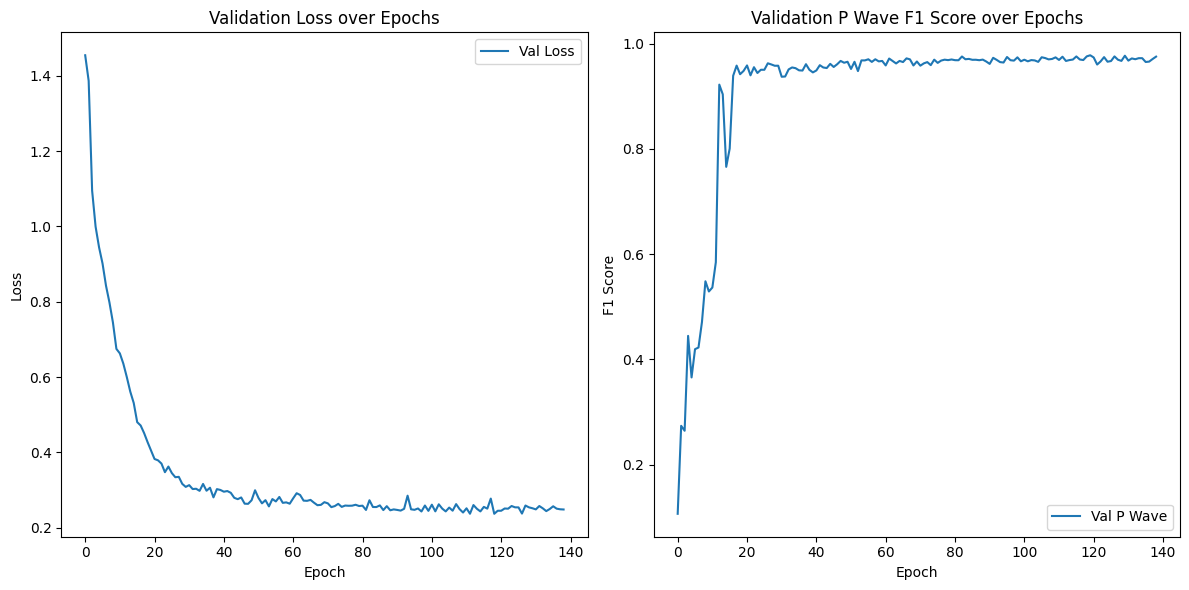

In [92]:
model.plot_metrics()

In [99]:
dict_ = torch.load('/home/meshalkin/Diplom/hdd/UNETNNGU/epoch=65_val_p_wave=0.971969.ckpt')['state_dict']
model.load_state_dict(dict_)
model.cuda()

model = model.eval()

analyzer = Analyser(model, val_loader)

In [100]:
# Получение усредненного детализированного отчета
detailed_avg_report = analyzer.detailed_avg_report()
print("Averaged Detailed Report:")
for metric_name, metric_value in detailed_avg_report.items():
    print(f"{metric_name}: {metric_value:.5f}")

# Получение усредненного краткого отчета
short_avg_report = analyzer.short_avg_report()
print(f"Averaged Short Report: {short_avg_report:.5f}")

Averaged Detailed Report:
p_onset: 0.95798
p_offset: 0.94562
t_onset: 0.98225
t_offset: 0.97377
qrs_onset: 0.99888
qrs_offset: 0.99888
Averaged Short Report: 0.97907


### 2.0 Подведение промежуточных результатов

|   | UNetNNGU |  DeepLabV3Plus1DDeeper | AttentionSegNet1D  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| p_onset | 0.85858  | 0.77403  | 0.83115  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| p_offset | 0.85400  | 0.78926  | 0.82901   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| t_onset | 0.92852  | 0.88835  | 0.87987  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| t_offset  | 0.93112  | 0.88879  | 0.87111  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| qrs_onset  | 0.97614  | 0.9665  | 0.96081 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| qrs_offset  | 0.97505  | 0.96513 | 0.95714  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| Params size (MB)  | 2.03  | 13.53  | 149.48  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| Training Time (sec) | 192.44  | 34.70  | 28.39  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
| Inference Time (sec) | 0.0144672  | 0.0298283  | 0.0282965   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
